In [1]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.3     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [2]:
setwd(here::here())

scdb_init("scrna_db/", force_reinit=T)
fig_dir <- "figs/"
if(!dir.exists(fig_dir)) {
    dir.create(fig_dir)
  }

scfigs_init(fig_dir)

mat_synembs <- scdb_mat("SynEmb3")
mc_synembs <- scdb_mc("SynEmb3_recolored_old")
md_synembs <- mat_synembs@cell_metadata[names(mc_synembs@mc),]

mat_wt <- scdb_mat("embexe")
mc_wt <- scdb_mc("embexe_recolored")
md_wt <- mat_wt@cell_metadata

mc_wt_emb = scdb_mc("emb")
mc_wt_exe = scdb_mc("exe")

mat <- scdb_mat("SynEmb3_embexe")

initializing scdb to scrna_db/



In [3]:
scdb_init("../../scrna_db/", force_reinit=T)
scdb_ls("mc", 'Syn')

initializing scdb to ../../scrna_db/



[1] "mc.SynEmb3"           "mc.SynEmb3_recolored"


In [4]:
color_key <- read.csv("data/embexe.cell_type_annotation.csv",row.names = "X", stringsAsFactors = F)

col_to_ct = color_key$cell_type
names(col_to_ct) = color_key$color

ct_to_col = color_key$color
names(ct_to_col) = color_key$cell_type

shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))

## Cell type frequencies and filtered wt embryos for matching

In [5]:
emb_cols <- color_key$color[1:38]
exe_cols <- color_key$color[43:50]

# WT cell type frecquencies:
embryo_to_col_wt <- table(factor(x = mc_wt@colors[mc_wt@mc],levels = color_key$color),
                          md_wt[names(mc_wt@mc),"embryo"])
embryo_to_col_wt_emb <- embryo_to_col_wt[emb_cols,] # subset of embryonic cell types
embryo_to_col_wt_exe <- embryo_to_col_wt[exe_cols,] # subset of ExE cell types

# SynEmbs cell type frecquencies:
embryo_to_col_synembs <- table(factor(x = mc_synembs@colors[mc_synembs@mc],levels = color_key$color),
                          md_synembs[,"embryo"])
# embryo_to_col_synembs <- embryo_to_col_synembs[, -which(colnames(embryo_to_col_synembs) == 'empty')]
embryo_to_col_synembs_emb <- embryo_to_col_synembs[emb_cols,] # subset of embryonic cell types
embryo_to_col_synembs_exe <- embryo_to_col_synembs[exe_cols,] # subset of ExE cell types

# filter embryos with a cell count that equals median cell count in synthetic embryos:
synembs_total_cl_count_per_embryo <- table(md_synembs[,"embryo"])
synembs_median_total_cl_count <- median(synembs_total_cl_count_per_embryo)

big_embs <- colnames(embryo_to_col_wt)[colSums(embryo_to_col_wt) >= synembs_median_total_cl_count]

# filter embryos with exe cells:
exe_count_per_synembs_embryo <- colSums(embryo_to_col_synembs_exe)
synembs_median_exe_cl_count <- median(exe_count_per_synembs_embryo)

exe_count_per_wt_embryo <- colSums(embryo_to_col_wt_exe)
wt_embs_with_exe <- names(exe_count_per_wt_embryo)[array(exe_count_per_wt_embryo) > synembs_median_exe_cl_count]

# filter embryos with developmental age:
wt_embryos_f <- intersect(big_embs,wt_embs_with_exe)
embs_with_age_df <- unique(md_wt[md_wt$embryo %in% wt_embryos_f, c("developmental_time",'embryo')])
embs_with_age_df <- embs_with_age_df[!is.na(embs_with_age_df$developmental_time),]

wt_embryos_ff <- intersect(wt_embryos_f,embs_with_age_df$embryo)
message("Embryos to match N = ",length(wt_embryos_f))

embs_with_age_df <- embs_with_age_df[embs_with_age_df$embryo %in% wt_embryos_ff,]
embs_with_age_df <- embs_with_age_df[order(embs_with_age_df$developmental_time, decreasing = F),]
wt_embryos_ff_ord <- embs_with_age_df$embryo

# WT normalized filtered cell type frecquencies:
embryo_to_col_wt_emb_n <- t(t(embryo_to_col_wt_emb[,wt_embryos_ff_ord])/colSums(embryo_to_col_wt_emb[,wt_embryos_ff_ord]))
embryo_to_col_wt_exe_n <- t(t(embryo_to_col_wt_exe[,wt_embryos_ff_ord])/colSums(embryo_to_col_wt_exe[,wt_embryos_ff_ord]))

# SynEmbs normalized cell type frecquencies:
embryo_to_col_synembs_emb_n <- t(t(embryo_to_col_synembs_emb)/colSums(embryo_to_col_synembs_emb))
embryo_to_col_synembs_exe_n <- t(t(embryo_to_col_synembs_exe)/colSums(embryo_to_col_synembs_exe))

Embryos to match N = 59



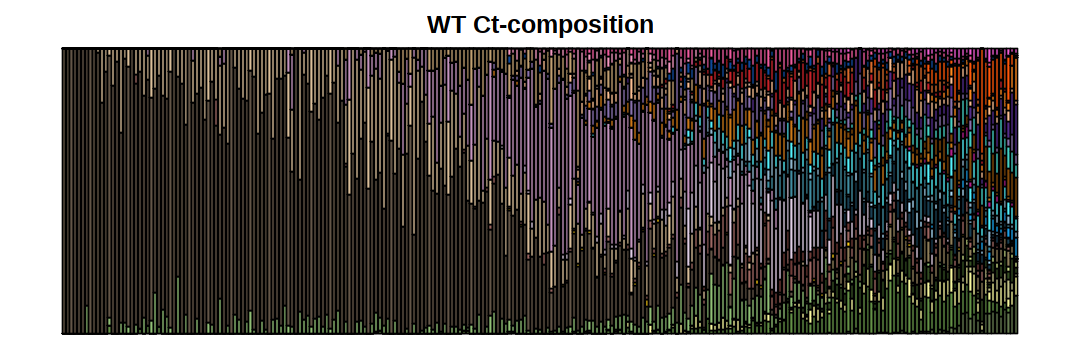

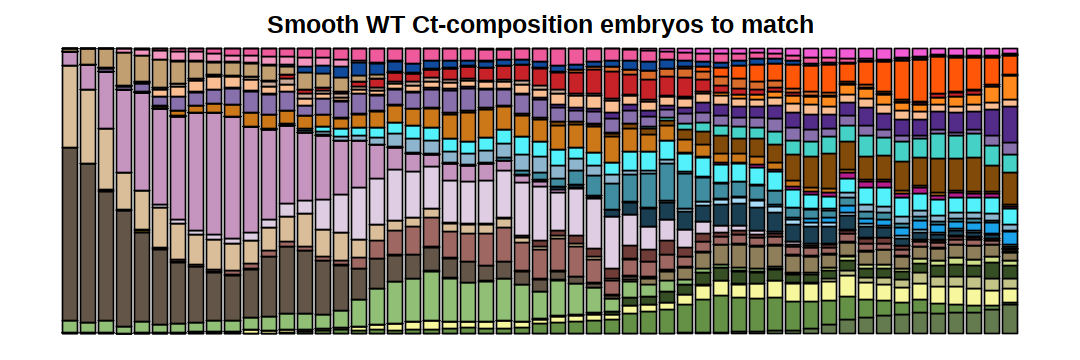

In [6]:
embs_with_age_df <- unique(md_wt[, c("developmental_time",'embryo')])
embs_with_age_df <- embs_with_age_df[!is.na(embs_with_age_df$developmental_time),]
embs_with_age_df <- embs_with_age_df[order(embs_with_age_df$developmental_time, decreasing = F),]

embs_ord <- embs_with_age_df$embryo
embs_ord <- embs_ord[embs_ord %in% colnames(embryo_to_col_wt_emb)]

embryo_to_col_wt_emb_n_not_filtered <- t(t(embryo_to_col_wt_emb[,embs_ord])/colSums(embryo_to_col_wt_emb[,embs_ord]))

options(repr.plot.width=9, repr.plot.height=3)

# pdf("figs/WT_Ct_comp.pdf", width = 9, height = 3, useDingbats = F)
par(mar = c(1,1,2,1))
barplot(embryo_to_col_wt_emb_n_not_filtered,col = rownames(embryo_to_col_wt_emb_n_not_filtered), main = "WT Ct-composition" ,yaxt="n", xaxt="n")
# dev.off()

# smoothing the wt cell-type composition
embryo_to_col_wt_emb_n_smoothed = t(apply(embryo_to_col_wt_emb_n,1,function(v) {return(rollmean(v, k = 3))}))

# pdf("figs/WT_smooth_Ct_comp.pdf", width = 9, height = 3, useDingbats = F)
par(mar = c(1,1,2,1))
barplot(embryo_to_col_wt_emb_n_smoothed,col = rownames(embryo_to_col_wt_emb_n_smoothed), main = "Smooth WT Ct-composition embryos to match" ,yaxt="n", xaxt="n")
# dev.off()

## FigS3a

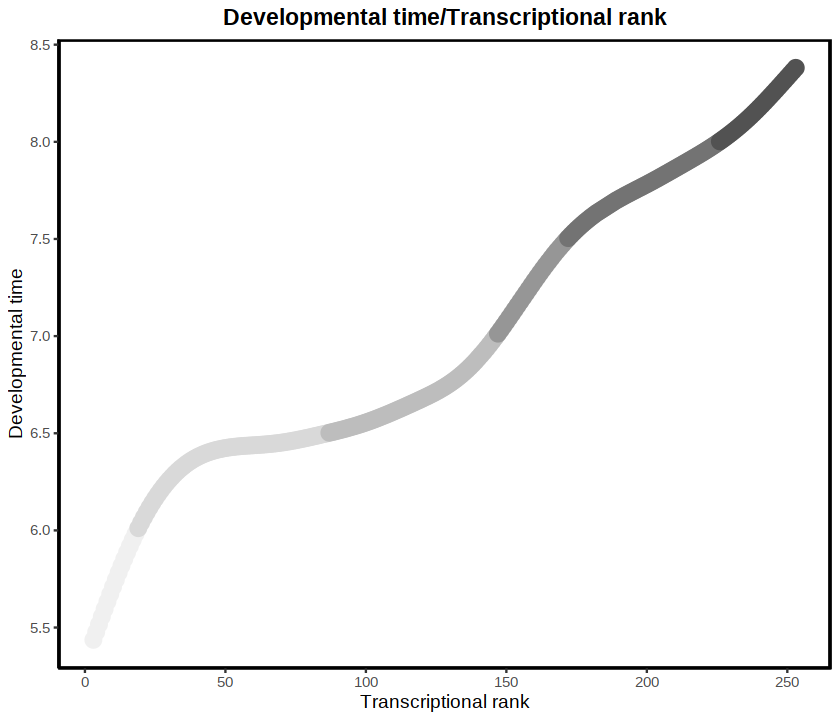

In [7]:
emb_ranks <- unique(md_wt[md_wt$embryo %in% embs_ord,c("embryo", "transcriptional_rank", "developmental_time")])
rownames(emb_ranks) <- emb_ranks$embryo
emb_ranks <- emb_ranks[embs_ord,]
emb_ranks$age_group <- NA
                               
emb_ranks$age_group[emb_ranks$developmental_time < 6] <- "5.5-6.0"
emb_ranks$age_group[(emb_ranks$developmental_time > 6) & (emb_ranks$developmental_time < 6.5)] <- "6.0-6.5"
emb_ranks$age_group[(emb_ranks$developmental_time > 6.5) & (emb_ranks$developmental_time < 7)] <- "6.5-7.0"
emb_ranks$age_group[(emb_ranks$developmental_time > 7) & (emb_ranks$developmental_time < 7.5)] <- "7.0-7.5"
emb_ranks$age_group[(emb_ranks$developmental_time > 7.5) & (emb_ranks$developmental_time < 8)] <- "7.5-8.0"
emb_ranks$age_group[emb_ranks$developmental_time > 8] <- "8.0-8.5"

age_group_levels <- c("5.5-6.0","6.0-6.5","6.5-7.0","7.0-7.5","7.5-8.0","8.0-8.5")
emb_ranks$age_group <- factor(emb_ranks$age_group, levels = age_group_levels)

age_group_cols = c(RColorBrewer::brewer.pal(9,"Greys")[2:7])
names(age_group_cols) <- age_group_levels
emb_ranks$age_group_cols <- array(age_group_cols)[match(emb_ranks$age_group, names(age_group_cols))]

emb_ranks_pinched <- emb_ranks[colnames(embryo_to_col_wt_emb_n_smoothed),]

synembs_embs_df <- data.frame("embryo" = unique(md_synembs$embryo))
synembs_embs <- synembs_embs_df[synembs_embs_df$embryo != "empty",]

xlabel = "Transcriptional rank"
ylabel = "Developmental time"
main_label = ""
cex.lab = 2
cex.axis = 2
cex.main = 2
cex = 2

options(repr.plot.width=7, repr.plot.height=6, useDingbats = F)

ggplot(data = emb_ranks, aes(x = transcriptional_rank, y = developmental_time, col = age_group_cols)) +
    geom_point(size = 4) +
    scale_color_identity() +
    ylab(ylabel) + 
    ggtitle(label = "Developmental time/Transcriptional rank") +
    xlab(xlabel) +
    scale_y_continuous(breaks = seq(from = 5,to = 8.5,length.out = 8)) +
    theme(plot.title = element_text(face = "bold",hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        panel.border = element_rect(fill=NA, size = 1))

In [8]:
# Euclidian distance matrix
dist_mat <- as.matrix(dist(rbind(t(embryo_to_col_synembs_emb_n),t(embryo_to_col_wt_emb_n_smoothed))))
dist_mat_pinched <- dist_mat[colnames(embryo_to_col_synembs_emb_n), colnames(embryo_to_col_wt_emb_n_smoothed)]

synemb_embs_6 <- grep("GD6",colnames(dist_mat),ignore.case = T,value = T)
synemb_embs_8 <- grep("GD8",colnames(dist_mat),ignore.case = T,value = T)

dist_mat_6 <- dist_mat[c(synemb_embs_6,colnames(embryo_to_col_wt_emb_n_smoothed)), c(synemb_embs_6,colnames(embryo_to_col_wt_emb_n_smoothed))]
dist_mat_8 <- dist_mat[c(synemb_embs_8,colnames(embryo_to_col_wt_emb_n_smoothed)), c(synemb_embs_8,colnames(embryo_to_col_wt_emb_n_smoothed))]

annotation_col = data.frame(group = c(rep('Day 6 EiTiX',length(synemb_embs_6)),as.character(emb_ranks_pinched$age_group)))
rownames(annotation_col) = rownames(dist_mat_6)

xp_to_col <- c("#C72228",age_group_cols)
names(xp_to_col) <- c("Day 6 EiTiX",age_group_levels)

annotation_colors = list(group = xp_to_col)

## Fig3c

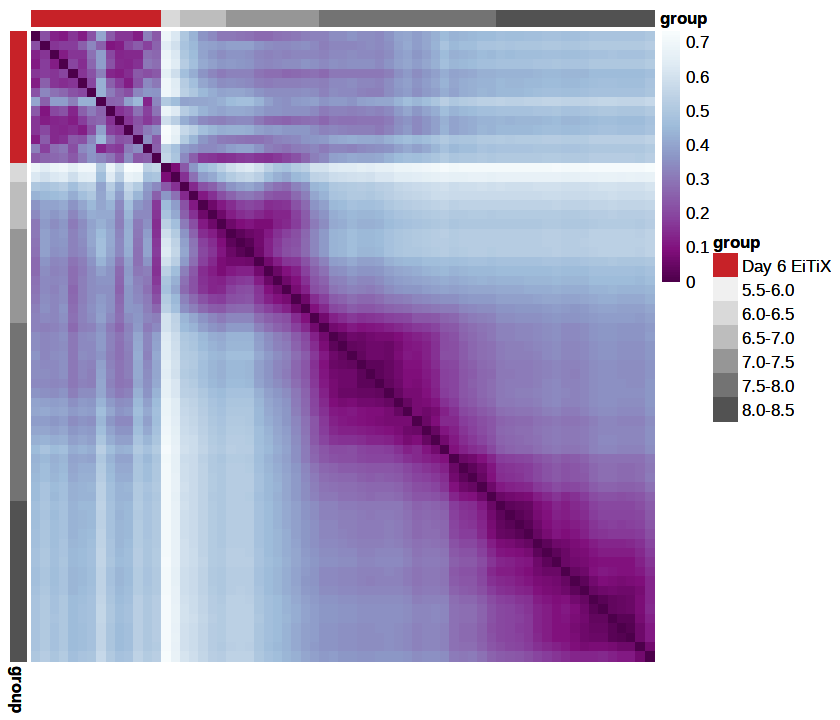

In [9]:
p6 <- pheatmap::pheatmap(dist_mat_6,
                 cluster_rows = F, 
                 cluster_cols = F,
                   annotation_col = annotation_col,
                   annotation_row = annotation_col,
                   annotation_colors = annotation_colors,
                   annotation_legend = T,
                   color = rev(shades_purples),
                   border_color = NA, 
                   show_rownames = F, 
                   show_colnames = F)

print(p6)

## Fig5b

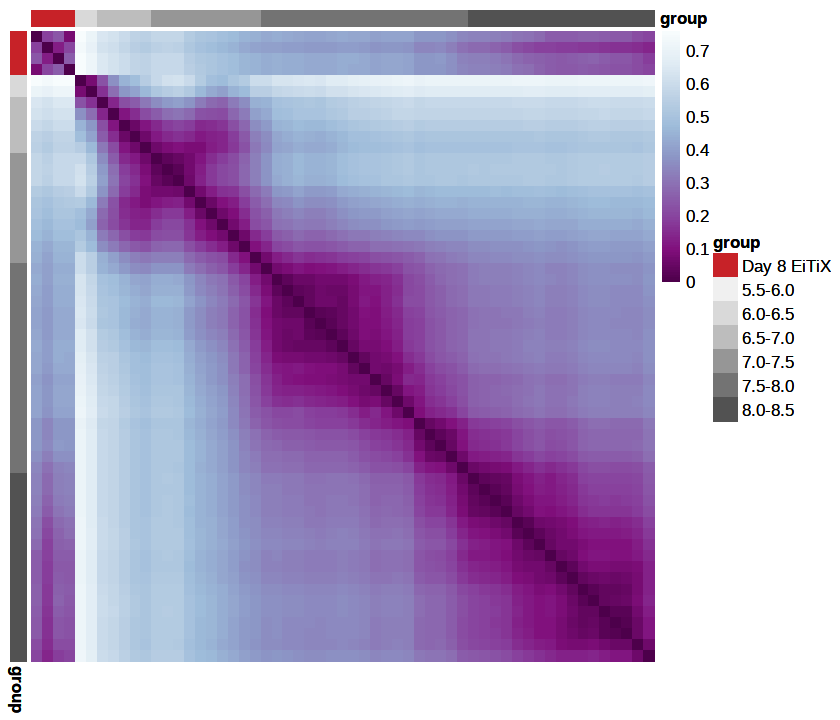

In [10]:
annotation_col = data.frame(group = c(rep('Day 8 EiTiX',length(synemb_embs_8)),as.character(emb_ranks_pinched$age_group)))
rownames(annotation_col) = rownames(dist_mat_8)

xp_to_col <- c("#C72228",age_group_cols)
names(xp_to_col) <- c("Day 8 EiTiX",age_group_levels)

annotation_colors = list(group = xp_to_col)

p8 <- pheatmap::pheatmap(dist_mat_8,
                 cluster_rows = F, 
                 cluster_cols = F,
                   annotation_col = annotation_col,
                   annotation_row = annotation_col,
                   annotation_colors = annotation_colors,
                   annotation_legend = T,
                   color = rev(shades_purples),
                   border_color = NA, 
                   show_rownames = F, 
                   show_colnames = F)

print(p8)

## Matching WT to SynEmbs - Cell type composition euclidian distance

In [11]:
matched_embs_dist_6_ls <- lapply(synemb_embs_6, function(emb){
    match_embs <- colnames(dist_mat_pinched)[order(dist_mat_pinched[emb,],decreasing = F)[1:3]]
    return(match_embs)})

matched_embs_dist_8_ls <- lapply(synemb_embs_8, function(emb){
    match_embs <- colnames(dist_mat_pinched)[order(dist_mat_pinched[emb,],decreasing = F)[1:3]]
    return(match_embs)})

synemb_embs_age_6_ls <- lapply(synemb_embs_6, function(emb){
    match_embs <- colnames(dist_mat_pinched)[order(dist_mat_pinched[emb,],decreasing = F)[1:3]]
    age_i <- mean(unique(md_wt[md_wt$embryo %in% match_embs, "developmental_time"]))
    return(age_i)})

synemb_embs_age_8_ls <- lapply(synemb_embs_8, function(emb){
    match_embs <- colnames(dist_mat_pinched)[order(dist_mat_pinched[emb,],decreasing = F)[1:3]]
    age_i <- mean(unique(md_wt[md_wt$embryo %in% match_embs, "developmental_time"]))
    return(age_i)})

matched_embs_dist_6 <- unique(unlist(matched_embs_dist_6_ls))
matched_embs_dist_8 <- unique(unlist(matched_embs_dist_8_ls))
matched_embs_dist_68 <- c(matched_embs_dist_6,matched_embs_dist_8)

synemb_embs_6_age <- unlist(synemb_embs_age_6_ls)
names(synemb_embs_6_age) <- rownames(dist_mat_pinched[synemb_embs_6,])
synemb_embs_8_age <- unlist(synemb_embs_age_8_ls)
names(synemb_embs_8_age) <- rownames(dist_mat_pinched[synemb_embs_8,])
synemb_embs_68_age <- c(synemb_embs_6_age,synemb_embs_8_age)

matched_cls_dist_6 <- rownames(md_wt)[md_wt$embryo %in% matched_embs_dist_6]
matched_cls_dist_8 <- rownames(md_wt)[md_wt$embryo %in% matched_embs_dist_8]
matched_cls_dist_68 <- c(matched_cls_dist_6,matched_cls_dist_8)

emb_age_syn <- synemb_embs_68_age[order(synemb_embs_68_age, decreasing = F)]
syn_emb_ord <- names(emb_age_syn)

emb_age_matched_df <- unique(md_wt[matched_cls_dist_68,c("embryo", "developmental_time")])
emb_age_matched_df <- emb_age_matched_df[order(emb_age_matched_df$developmental_time, decreasing = F),]
emb_age_matched <- emb_age_matched_df$developmental_time
names(emb_age_matched) <- emb_age_matched_df$embryo
matched_emb_ord <- names(emb_age_matched)

sprintf("Matching WT embryo number (GD6): %s -> cell count: %s", length(matched_embs_dist_6), length(matched_cls_dist_6))
sprintf("Matching WT embryo number (GD8): %s -> cell count: %s", length(matched_embs_dist_8), length(matched_cls_dist_8))

[1] "Matching WT embryo number (GD6): 15 -> cell count: 7066"

[1] "Matching WT embryo number (GD8): 4 -> cell count: 5578"

In [12]:
matched_embs_dist_8

[1] "EXE28_e3"   "EXE19_M1E2" "EXE19_M1E4" "EXE19_M1E5"

In [13]:
synembs_cls_f <- intersect(colnames(mat@mat), names(mc_synembs@mc))
synembs_cls_ff <- intersect(synembs_cls_f, colnames(mat_synembs@mat))
wt_cls_f <- intersect(colnames(mat@mat), names(mc_wt@mc))
wt_cls_ff <- intersect(wt_cls_f, colnames(mat_wt@mat))

synembs_gd6_cls <- rownames(md_synembs)[md_synembs$embryo %in% synemb_embs_6]
synembs_gd8_cls <- rownames(md_synembs)[md_synembs$embryo %in% synemb_embs_8]

synembs_cls_6 <- synembs_gd6_cls[synembs_gd6_cls %in% synembs_cls_ff]
matched_cls_6 <- matched_cls_dist_6[matched_cls_dist_6 %in% wt_cls_ff]
synembs_cls_8 <- synembs_gd8_cls[synembs_gd8_cls %in% synembs_cls_ff]
matched_cls_8 <- matched_cls_dist_8[matched_cls_dist_8 %in% wt_cls_ff]

matched_cls <- c(matched_cls_6,matched_cls_8)
synembs_cls <- c(synembs_cls_6,synembs_cls_8)

df_syn <- data.frame("embryo" = names(emb_age_syn),
                     "age" = array(emb_age_syn))
rownames(df_syn) = df_syn$embryo
df_syn <- df_syn[order(df_syn$age),]
df_syn$type <- NA
df_syn[rownames(df_syn) %in% synemb_embs_6,"type"] <- "GD6 Synthetic"
df_syn[rownames(df_syn) %in% synemb_embs_8,"type"] <- "GD8 Synthetic"

df_control = data.frame("embryo" = names(emb_age_matched), 
                        "age" = array(emb_age_matched))
rownames(df_control) = df_control$embryo
df_control <- df_control[order(df_control$age),]
df_control$type <- NA
df_control[rownames(df_control) %in% matched_embs_dist_6,"type"] <- "GD6 Matching"
df_control[rownames(df_control) %in% matched_embs_dist_8,"type"] <- "GD8 Matching"

## Fig3d and Fig5c

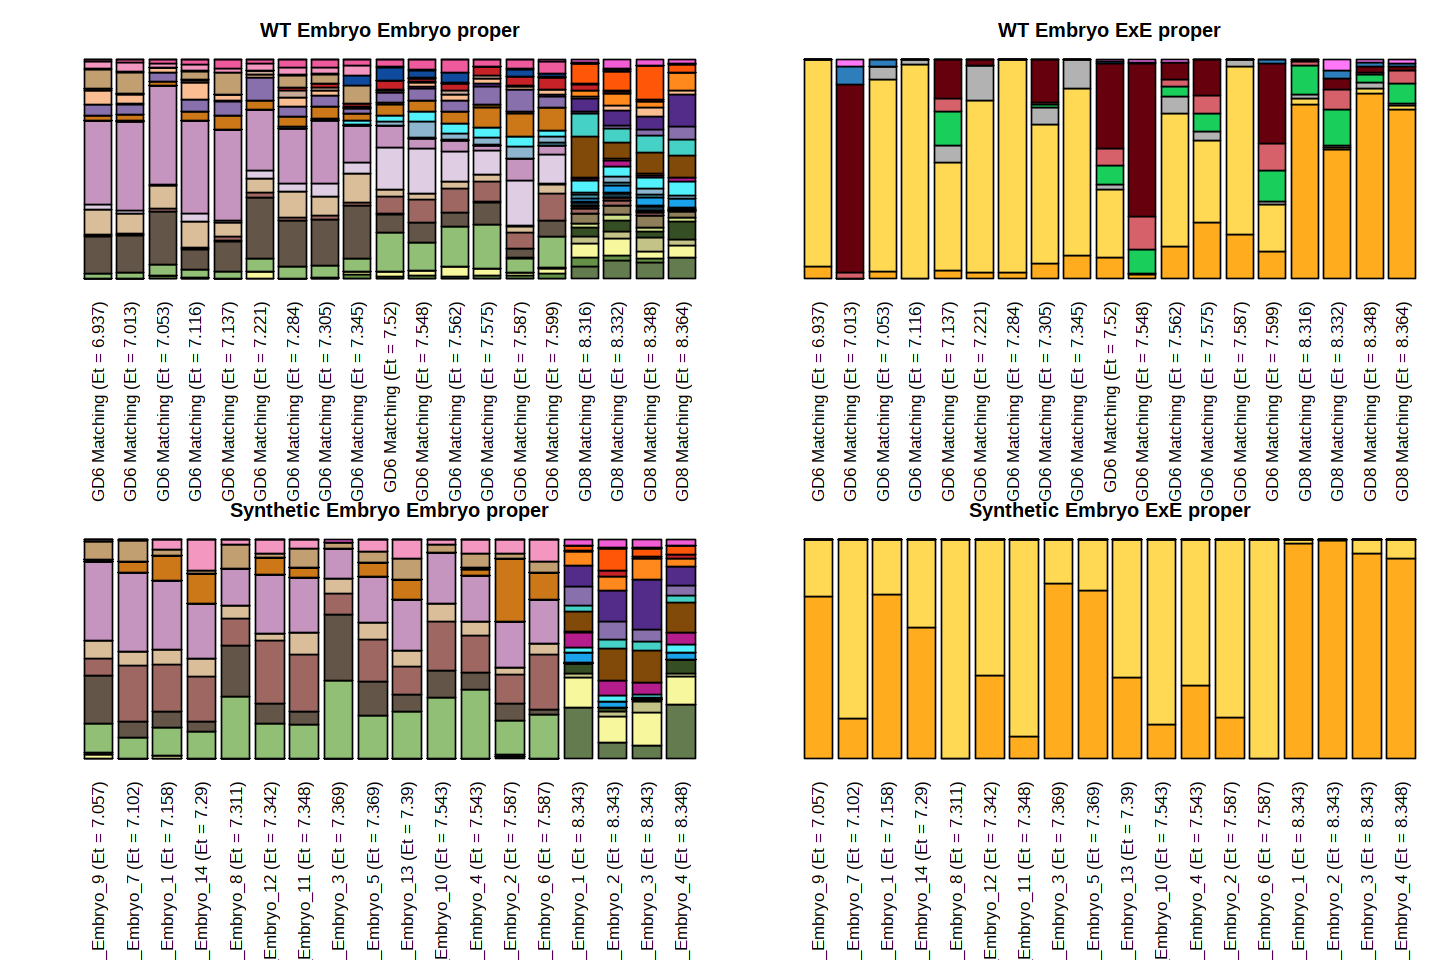

In [14]:
# filter wt embryos to matching ones:
embryo_to_col_wt_emb_n <- embryo_to_col_wt_emb_n[,matched_emb_ord]
embryo_to_col_wt_exe_n <- embryo_to_col_wt_exe_n[,matched_emb_ord]

# Order SynEmbs by age:
embryo_to_col_synembs_emb_n <- embryo_to_col_synembs_emb_n[,syn_emb_ord]
embryo_to_col_synembs_exe_n <- embryo_to_col_synembs_exe_n[,syn_emb_ord]

synemb_arg_names <- sprintf("%s (Et = %s)",df_syn$embryo,round(df_syn$age, 3))
wt_arg_names <- sprintf("%s (Et = %s)",df_control$type,round(df_control$age, 3))

options(repr.plot.width = 12, repr.plot.height = 8)
par(mar = c(10,3,3,0), mfrow = c(2,2))
barplot(embryo_to_col_wt_emb_n,
        col = rownames(embryo_to_col_wt_emb_n),
        las = 2, 
        main = "WT Embryo Embryo proper" ,
        yaxt="n", names.arg = wt_arg_names)
barplot(embryo_to_col_wt_exe_n,
        col = rownames(embryo_to_col_wt_exe_n), 
        las = 2, main = "WT Embryo ExE proper",
        yaxt="n", names.arg = wt_arg_names)
barplot(embryo_to_col_synembs_emb_n,
        col = rownames(embryo_to_col_synembs_emb_n),
        las = 2, main = "Synthetic Embryo Embryo proper",
        yaxt="n", names.arg = synemb_arg_names)
barplot(embryo_to_col_synembs_exe_n,
        col = rownames(embryo_to_col_synembs_exe_n), 
        las = 2, main = "Synthetic Embryo ExE proper",
        yaxt="n", names.arg = synemb_arg_names)

## Fig3 F+I and FigS3c and FigS4a

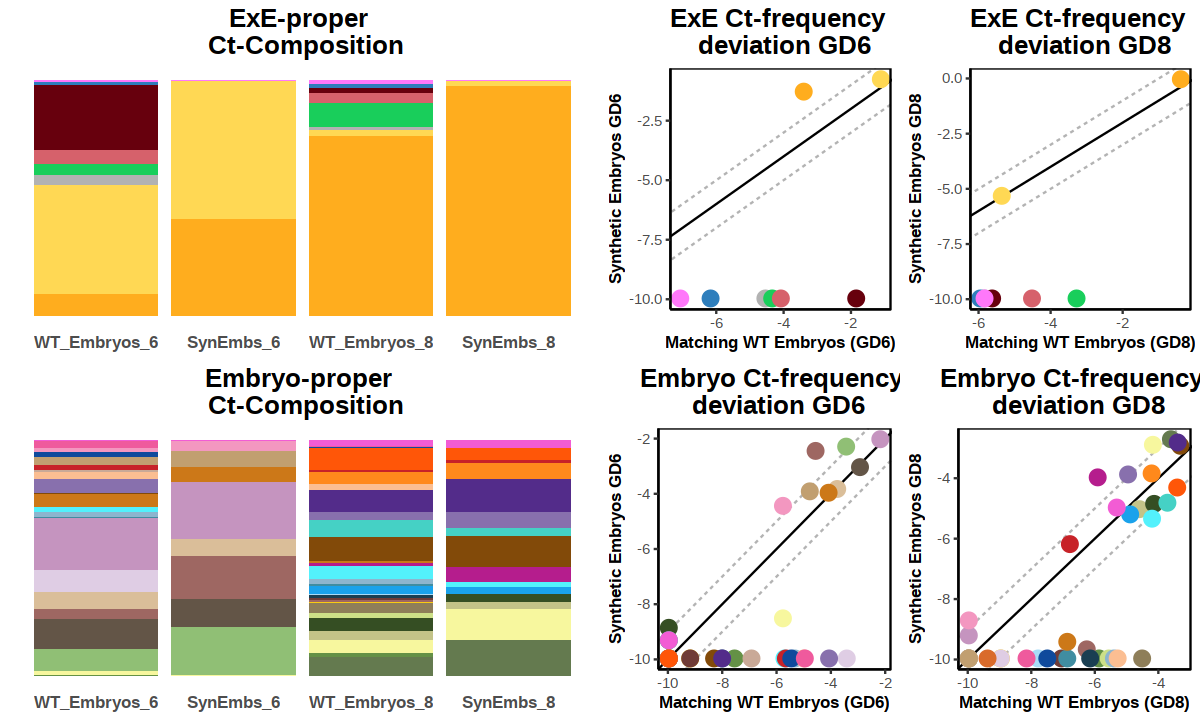

In [15]:
set.seed(321)
cls.wt.DnSmp.6 <- sample(matched_cls_dist_6,length(synembs_cls_6))
set.seed(321)
cls.wt.DnSmp.8 <- sample(matched_cls_dist_8,length(synembs_cls_8))
cls.wt.DnSmp.68 <- c(cls.wt.DnSmp.6, cls.wt.DnSmp.8)

embryo_to_col_wt_DnSmp <- table(factor(x = mc_wt@colors[mc_wt@mc[cls.wt.DnSmp.68]], levels = c(emb_cols,exe_cols)),
                          md_wt[cls.wt.DnSmp.68,"embryo"])

embryo_to_col_wt_emb <- embryo_to_col_wt_DnSmp[emb_cols,] # subset of embryonic cell types
embryo_to_col_wt_exe <- embryo_to_col_wt_DnSmp[exe_cols,] # subset of ExE cell types
embryo_to_col_synembs_emb <- embryo_to_col_synembs[emb_cols,] # subset of embryonic cell types
embryo_to_col_synembs_exe <- embryo_to_col_synembs[exe_cols,] # subset of ExE cell types

wt_6_emb <- rowSums(embryo_to_col_wt_emb[,matched_embs_dist_6])/sum(rowSums(embryo_to_col_wt_emb[,matched_embs_dist_6]))
wt_6_exe <- rowSums(embryo_to_col_wt_exe[,matched_embs_dist_6])/sum(rowSums(embryo_to_col_wt_exe[,matched_embs_dist_6]))
wt_8_emb <- rowSums(embryo_to_col_wt_emb[,matched_embs_dist_8])/sum(rowSums(embryo_to_col_wt_emb[,matched_embs_dist_8]))
wt_8_exe <- rowSums(embryo_to_col_wt_exe[,matched_embs_dist_8])/sum(rowSums(embryo_to_col_wt_exe[,matched_embs_dist_8]))

syn_6_emb <- rowSums(embryo_to_col_synembs_emb[,synemb_embs_6])/sum(rowSums(embryo_to_col_synembs_emb[,synemb_embs_6]))
syn_6_exe <- rowSums(embryo_to_col_synembs_exe[,synemb_embs_6])/sum(rowSums(embryo_to_col_synembs_exe[,synemb_embs_6]))
syn_8_emb <- rowSums(embryo_to_col_synembs_emb[,synemb_embs_8])/sum(rowSums(embryo_to_col_synembs_emb[,synemb_embs_8]))
syn_8_exe <- rowSums(embryo_to_col_synembs_exe[,synemb_embs_8])/sum(rowSums(embryo_to_col_synembs_exe[,synemb_embs_8]))

pool_col_wide_emb = data.frame(WT_Embryos_6 = as.vector(wt_6_emb), 
                               SynEmbs_6 = as.vector(syn_6_emb),
                               WT_Embryos_8 = as.vector(wt_8_emb), 
                               SynEmbs_8 = as.vector(syn_8_emb),
                               col = color_key$color[c(1:38)])

pool_col_wide_exe = data.frame(WT_Embryos_6 = as.vector(wt_6_exe), 
                               SynEmbs_6 = as.vector(syn_6_exe),
                               WT_Embryos_8 = as.vector(wt_8_exe), 
                               SynEmbs_8 = as.vector(syn_8_exe),
                               col = color_key$color[c(43:50)])

pool_col_wide_emb_long <- data.frame(tidyr::pivot_longer(data = pool_col_wide_emb, cols = c(1:4)))
pool_col_wide_emb_long$name <- factor(pool_col_wide_emb_long$name, levels = c("WT_Embryos_6","SynEmbs_6","WT_Embryos_8","SynEmbs_8"))
pool_col_wide_exe_long <- data.frame(tidyr::pivot_longer(data = pool_col_wide_exe, cols = c(1:4)))
pool_col_wide_exe_long$name <- factor(pool_col_wide_exe_long$name, levels = c("WT_Embryos_6","SynEmbs_6","WT_Embryos_8","SynEmbs_8"))

pool_col_wide_emb_long$col <- factor(pool_col_wide_emb_long$col, levels = rev(color_key$color[c(1:38)]))
pool_col_wide_exe_long$col <- factor(pool_col_wide_exe_long$col, levels = rev(color_key$color[c(43:50)]))

df.plot.emb <- data.frame(WT_Embryos_6 = log2(pool_col_wide_emb$WT_Embryos_6 + 1e-3),
                          SynEmbs_6 = log2(pool_col_wide_emb$SynEmbs_6 + 1e-3),
                          WT_Embryos_8 = log2(pool_col_wide_emb$WT_Embryos_8 + 1e-3),
                          SynEmbs_8 = log2(pool_col_wide_emb$SynEmbs_8 + 1e-3),
                          cell_type_color = pool_col_wide_emb$col)

df.plot.exe <- data.frame(WT_Embryos_6 = log2(pool_col_wide_exe$WT_Embryos_6 + 1e-3),
                          SynEmbs_6 = log2(pool_col_wide_exe$SynEmbs_6 + 1e-3),
                          WT_Embryos_8 = log2(pool_col_wide_exe$WT_Embryos_8 + 1e-3),
                          SynEmbs_8 = log2(pool_col_wide_exe$SynEmbs_8 + 1e-3),
                          cell_type_color = pool_col_wide_exe$col)

p1 <- ggplot(pool_col_wide_emb_long, aes(name, value, fill = col)) +
  geom_col() +
  ggtitle("Embryo-proper \n Ct-Composition") +
  scale_fill_identity() +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.line = element_blank(),
        axis.text.y = element_blank(),
        axis.text.x = element_text(face = "bold",size = 10),
        axis.title = element_blank(),
        panel.grid = element_blank(),panel.border = element_blank(), legend.position="None")

p2 <- ggplot(pool_col_wide_exe_long, aes(name, value, fill = col)) +
  geom_col() +
  ggtitle("ExE-proper \n Ct-Composition") +
  scale_fill_identity() +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.ticks = element_blank(),
        axis.line = element_blank(),
        axis.text.y = element_blank(),
        axis.text.x = element_text(face = "bold",size = 10),
        axis.title = element_blank(),
        panel.grid = element_blank(),panel.border = element_blank(), legend.position="None")

p3 <- ggplot(data = df.plot.emb,aes(WT_Embryos_6, SynEmbs_6, col=cell_type_color)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
  ggtitle(label = "Embryo Ct-frequency \n deviation GD6") +
  scale_color_identity() +
  ylab("Synthetic Embryos GD6") +
  xlab("Matching WT Embryos (GD6)") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.title = element_text(face = "bold",size = 10),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

p4 <- ggplot(data = df.plot.exe,aes(WT_Embryos_6, SynEmbs_6, col=cell_type_color)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
  ggtitle(label = "ExE Ct-frequency \n deviation GD6") +
  scale_color_identity() +
  ylab("Synthetic Embryos GD6") +
  xlab("Matching WT Embryos (GD6)") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.title = element_text(face = "bold",size = 10),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

p5 <- ggplot(data = df.plot.emb,aes(WT_Embryos_8, SynEmbs_8, col=cell_type_color)) +
    geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
  ggtitle(label = "Embryo Ct-frequency \n deviation GD8") +
  scale_color_identity() +
  ylab("Synthetic Embryos GD8") +
  xlab("Matching WT Embryos (GD8)") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.title = element_text(face = "bold",size = 10),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

p6 <- ggplot(data = df.plot.exe,aes(WT_Embryos_8, SynEmbs_8, col=cell_type_color)) +
  geom_abline(slope = 1,intercept = 0) +
  geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
  geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +
  geom_point(size = 4) +
  ggtitle(label = "ExE Ct-frequency \n deviation GD8") +
  scale_color_identity() +
  ylab("Synthetic Embryos GD8") +
  xlab("Matching WT Embryos (GD8)") +
  theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
        axis.title = element_text(face = "bold",size = 10),
        panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

options(repr.plot.width=10, repr.plot.height=6)
gridExtra::grid.arrange(gridExtra::arrangeGrob(p2,p1), gridExtra::arrangeGrob(p4,p6,p3, p5), ncol = 2)

## Fig5f

[1] 97.26

Embryonic cells proportion = 2.74 [11]

ExE cells proportion = 97.26 [390]



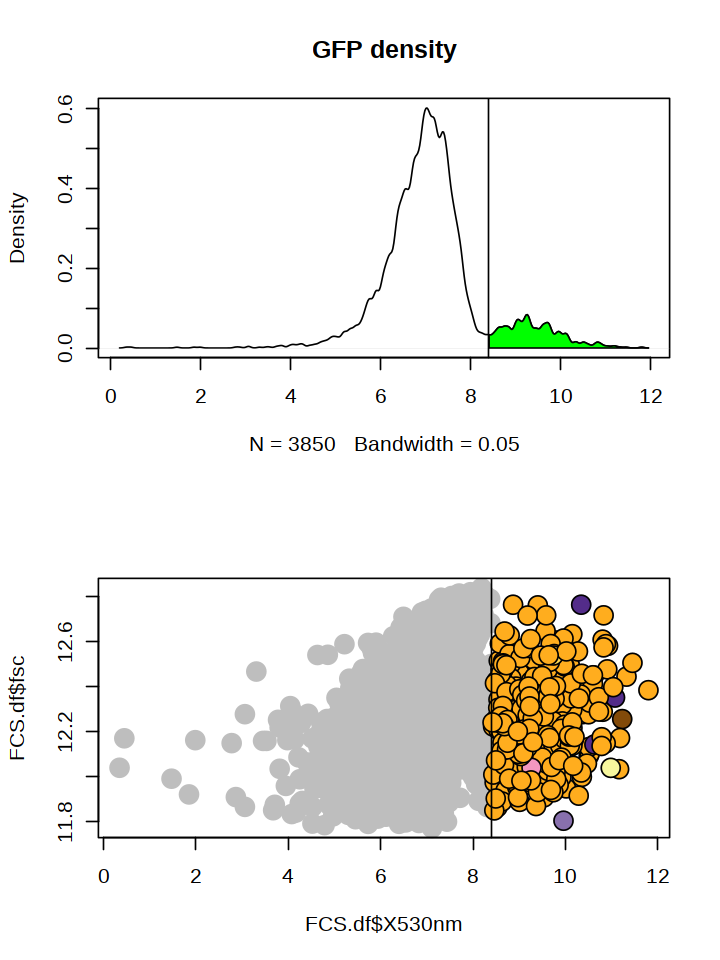

In [16]:
arsinh = function(x,a = 1,b = 1) {
  
  return(log(x + sqrt(x^2/a^2 + b/a)))
}

calc_a_b_from_x_y = function(x1,y1,x2,y2) {
  
  b = (y2 - y1)/(x2 - x1)
  a = (y1*x2 - x1*y2)/(x2 - x1) 
  return(c(a,b))
}

a_x = 1
b_x = 1000
a_y = 1
b_y = 1000

############################################
md_synembs <- md_synembs[synembs_cls,]

FCS.df <- data.frame("450nm" = arsinh(md_synembs$x450_40_violet_a, a= a_x,b = b_x), 
                     "530nm" = arsinh(md_synembs$x530_30_blue_a, a= a_x,b = b_x), 
                     "582nm" = arsinh(md_synembs$x582_15_y_g_a, a= a_x,b = b_x), 
                     "fsc" = arsinh(md_synembs$fsc_a, a= a_x,b = b_x), 
                     "ssc" = arsinh(md_synembs$ssc_a, a= a_x,b = b_x), 
                     row.names = synembs_cls)

syn_sc_col <- mc_synembs@colors[mc_synembs@mc]
names(syn_sc_col) <- names(mc_synembs@mc)
syn_sc_col <- syn_sc_col[synembs_cls]

FCS.df$col <- syn_sc_col
FCS.df <- FCS.df[!is.na(FCS.df$X582nm),]
FCS.df <- FCS.df[intersect(rownames(FCS.df), synembs_cls_8),]

density_450 <- density(FCS.df$X450nm, bw = 0.05)
density_530 <- density(FCS.df$X530nm, bw = 0.05)
density_582 <- density(FCS.df$X582nm, bw = 0.05)

options(repr.plot.width=6, repr.plot.height=8)
par(mfrow = c(2,1))

plot(density_530,
     main = "GFP density")

x_low <- min(which(density_530$x >= 8.4))
x_high <- max(which(density_530$x >= 8.4))

with(density_530,  
     polygon(x = c(x[c(x_low, x_low:x_high, x_high)]),
             y = c(0, y[x_low:x_high], 0),
             col = "green"))
abline(v = 8.4)

pos_cls <- rownames(FCS.df)[FCS.df$X530nm > 8.4]

plot(FCS.df$X530nm, FCS.df$fsc, pch = 19, col = "grey", cex = 2)
points(FCS.df[pos_cls,"X530nm"], FCS.df[pos_cls,"fsc"] , pch = 21, bg = FCS.df[pos_cls,"col"], cex = 2)
abline(v = 8.4)

### percentc
subdf <- FCS.df[pos_cls,]
subdf_emb <- subdf[subdf$col %in% emb_cols,]
subdf_exe <- subdf[subdf$col %in% exe_cols,]

round(nrow(subdf_exe)*100/nrow(subdf),2)

message("Embryonic cells proportion = ", round(nrow(subdf_emb)*100/nrow(subdf),2)," [",nrow(subdf_emb),"]" )
message("ExE cells proportion = ", round(nrow(subdf_exe)*100/nrow(subdf),2)," [",nrow(subdf_exe),"]" )

# Differential gene expression analysis

In [17]:
# synembs emb
epiblast_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#635547"]
primitive_streak_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#DABE99"]
early_nascent_mesoderm_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#C594BF"]
exe_mesoderm_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#8870ad"]
amnion_chorion_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#824A09"]
allantois_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#532C8A"]
cardiopharyngeal_mesoderm_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#53f1fc"]
cardiomyocytes_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#B51D8D"]
forebrain_midbrain_hindbrain_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#647A4F"]
somitic_mesoderm_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#1AA2EB"]
hindgut_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#F25CD4"]
allantois_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#532C8A"]
anterior_primitive_streak_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#c19f70"]
erythroid_3_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#FF5608"]

# synembs EXE
chp_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#ffd854"]
chorion_synembs <- names(mc_synembs@mc)[mc_synembs@colors[mc_synembs@mc] == "#ffad1e"]

all_synembs_cls <- c(epiblast_synembs,
                    chp_synembs,
                     anterior_primitive_streak_synembs,
                     somitic_mesoderm_synembs,
                     hindgut_synembs,
                     allantois_synembs,
                     exe_mesoderm_synembs,
                     amnion_chorion_synembs,
                     cardiopharyngeal_mesoderm_synembs,
                     cardiomyocytes_synembs,
                     erythroid_3_synembs,
                    early_nascent_mesoderm_synembs,   
                     forebrain_midbrain_hindbrain_synembs,
                    primitive_streak_synembs,
                    chorion_synembs)

####################################################################################################
# WT emb
epiblast_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#635547"]
primitive_streak_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#DABE99"]
early_nascent_mesoderm_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#C594BF"]
exe_mesoderm_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#8870ad"]
amnion_chorion_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#824A09"]
allantois_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#532C8A"]
cardiopharyngeal_mesoderm_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#53f1fc"]
cardiomyocytes_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#B51D8D"]
forebrain_midbrain_hindbrain_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#647A4F"]
somitic_mesoderm_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#1AA2EB"]
hindgut_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#F25CD4"]
allantois_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#532C8A"]
anterior_primitive_streak_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#c19f70"]
erythroid_3_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#FF5608"]

# WT EXE
chp_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#ffd854"]
chorion_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#ffad1e"]

all_wt_cls <- c(epiblast_cls,
                exe_mesoderm_cls,
                somitic_mesoderm_cls,
                hindgut_cls,
                allantois_cls,
                amnion_chorion_cls,
                anterior_primitive_streak_cls,
                forebrain_midbrain_hindbrain_cls,
                allantois_cls,
                cardiopharyngeal_mesoderm_cls,
                cardiomyocytes_cls,
                chp_cls,
                primitive_streak_cls,
                early_nascent_mesoderm_cls,
                erythroid_3_cls,
                chorion_cls)

####################################################################################################

cls <- c(all_wt_cls,all_synembs_cls)
cls <- intersect(cls, colnames(mat@mat))

scdb_init("scrna_db/", force_reinit = T)
gset_wt <- scdb_gset("embexe")
wt_feature_genes <- names(gset_wt@gene_set)
gset_wt_emb_markers <- scdb_gset("emb_marker")
emb_markers <- names(gset_wt@gene_set)

gns <- unique(wt_feature_genes, emb_markers)

bad_genes <- read.table("data/embexe.bad_genes.txt", header = T, sep = "\t", stringsAsFactors = F)[,1]
gns <- setdiff(rownames(mat@mat),bad_genes)

initializing scdb to scrna_db/



In [18]:
mcell_gset_from_mc_markers(gset_id = "embexe_marker",mc_id = "embexe_recolored")
gset <- scdb_gset(id = "embexe_marker")
feature.genes <- names(gset@gene_set)

find_mcs <- function(color, mc){
    
    metacell_obj <- get(x = mc, envir = .GlobalEnv)
    Ct = color_key$cell_type[color_key$color == color]
    Ct_nm_adjust <- gsub("/| |-", replacement = "_", x = Ct)
    
    mcs <- which(metacell_obj@colors == color)
    assign(x = sprintf("%s_mcs", tolower(Ct_nm_adjust)), value = mcs, envir = .GlobalEnv)
}

for(col in color_key$color){find_mcs(col, "mc_wt")}

for(ct in color_key$cell_type[c(1:41)]){
    
    Ct <- gsub("/| |-", replacement = "_", x = ct)
    Ct_mcs <- get(sprintf("%s_mcs", tolower(Ct)))
    
    legc = log2(mc_wt@e_gc + 1e-5)
    legc_n <- legc - rowMeans(legc)

    gexp1 <- rowMeans(legc_n[intersect(feature.genes, rownames(mc_wt@e_gc)),Ct_mcs])
    gexp2 <- rowMeans(legc_n[intersect(feature.genes, rownames(mc_wt@e_gc)),-(Ct_mcs)])

    diff <- gexp1 - gexp2
    Ct_gns <- names(head(sort(diff,decreasing = T),n = 5))
    assign(x = sprintf("gmod_%s", tolower(Ct)), value = Ct_gns, envir = .GlobalEnv)    
}

gmod_primitive_streak <- c(gmod_primitive_streak, "T")
gmod_chorion <- c("Ascl2", "Fgfr2", "Cited1", "Gjb3", "Ndrg1", "Irx2", "Irx3")
gmod_chp <- c("Sox3", "Dusp6", "Nat8l", "Bmp4", "Sox2", "Esrrb", "Eomes")

In [19]:
egc_n <- t(t(mat@mat)/colSums(mat@mat))
egc_n <- egc_n[gns,cls]

In [20]:
dge_ct <- function(ct, day, fc){
    wt_cels <- get(x = sprintf("%s_cls", ct),envir = .GlobalEnv)
    syn_cels <- get(x = sprintf("%s_synembs", ct),envir = .GlobalEnv)
    day_syn <- get(x = sprintf("synembs_cls_%s", day),envir = .GlobalEnv) 
    day_cls <- get(x = sprintf("matched_cls_%s", day),envir = .GlobalEnv) 
    
    fn <- sprintf("figs/dge_%s_day%s.pdf", ct, day)
    dge1 <- matrix(rowMeans(egc_n[,intersect(wt_cels, day_cls)]),dimnames = list(c(row.names(egc_n))))
    dge2 <- matrix(rowMeans(egc_n[,intersect(syn_cels, day_syn)]),dimnames = list(c(row.names(egc_n))))
    title.nm <- sprintf("%s", ct)

    temp <- cbind(dge2[,1],dge1[,1])
    colnames(temp) <- c("gexp.2", "gexp.1")
    temp <- as.data.frame(temp)
    temp$log.2 <- log2(temp$gexp.2 + 1e-4)
    temp$log.1 <- log2(temp$gexp.1 + 1e-4)
    temp$diff.2 <- log2(temp$gexp.2 + 1e-4) - log2(temp$gexp.1 + 1e-4)
    temp$diff.1 <- log2(temp$gexp.1 + 1e-4) - log2(temp$gexp.2 + 1e-4)

    up <- rownames(temp)[temp$diff.1 > fc]
    dn <- rownames(temp)[temp$diff.2 > fc]
    mark <- get(x = sprintf("gmod_%s", ct),envir = .GlobalEnv)

    rnms <- rownames(temp)
    rnms <- subset(rnms , rnms %in% c(up,dn,mark))

    temp$log <- NA
    temp$log[rownames(temp) %in% dn] <- "dn"
    temp$log[rownames(temp) %in% up] <- "up"
    temp$log[rownames(temp) %in% mark] <- "mark"
    temp$log[which(is.na(temp$log))] <- "n"


    pa <- ggplot(data = temp,aes(log.1,log.2,col=log)) +
      geom_point(size = 2) +
      geom_abline(slope = 1,col="darkgrey") +
      ggtitle(title.nm) +
      xlab(sprintf("Log2(Absolute expression) Day%s EiTiX %s cells", day,ct)) +
      ylab(sprintf("Log2(Absolute expression) WT %s cells", ct)) +
        theme(plot.title = element_text(face = "bold",hjust = 0.5)) +

      scale_color_manual(values = c("up"=RColorBrewer::brewer.pal(9,"Reds")[7],
                                    "dn"=RColorBrewer::brewer.pal(9,"Blues")[8],
                                    "mark"="black",
                                    "n"="#CCCCCC"))

    p1 <- pa  + geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                                max.overlaps = 50,
                                aes(log.1,
                                    log.2,
                                    label=rnms, 
                                    col  = "#000000",
                                    size = 10)) +

                geom_point(data=subset(temp, rownames(temp) %in% rnms),
                         aes(log.1,log.2), size = 2) +

                theme(legend.position = "none", text = element_text(size = 10),
                    panel.border = element_rect(fill=NA, size = 1))

    p1
}

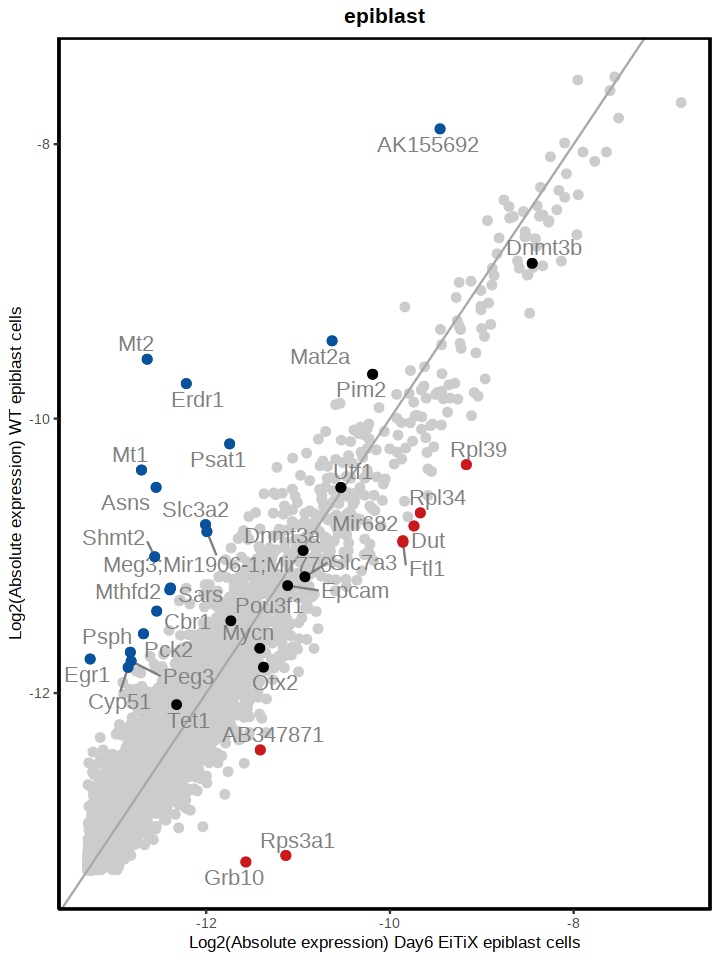

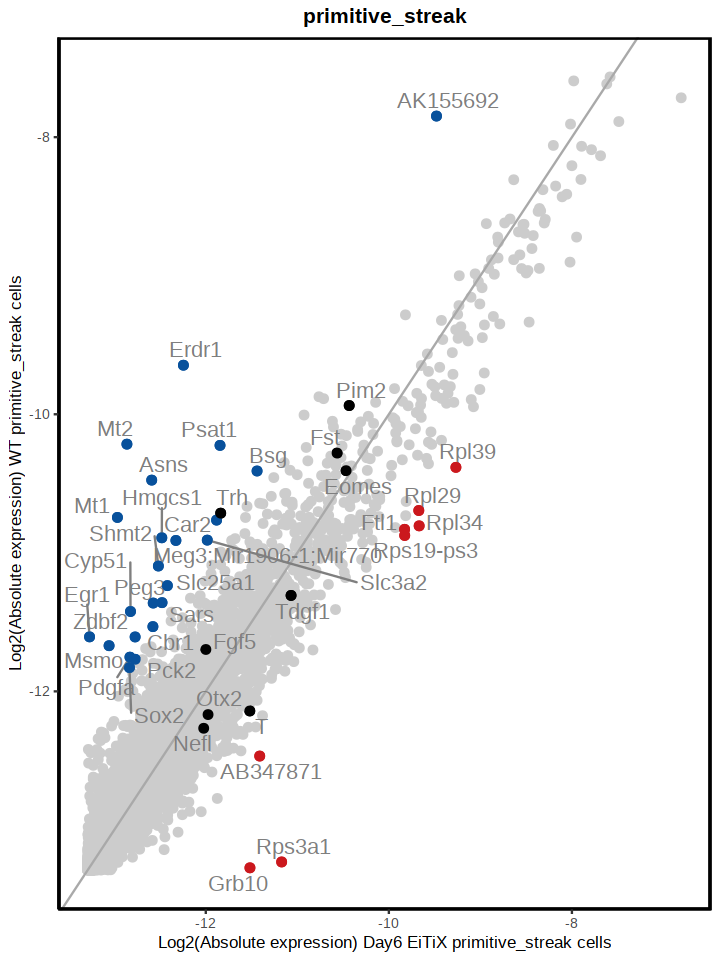

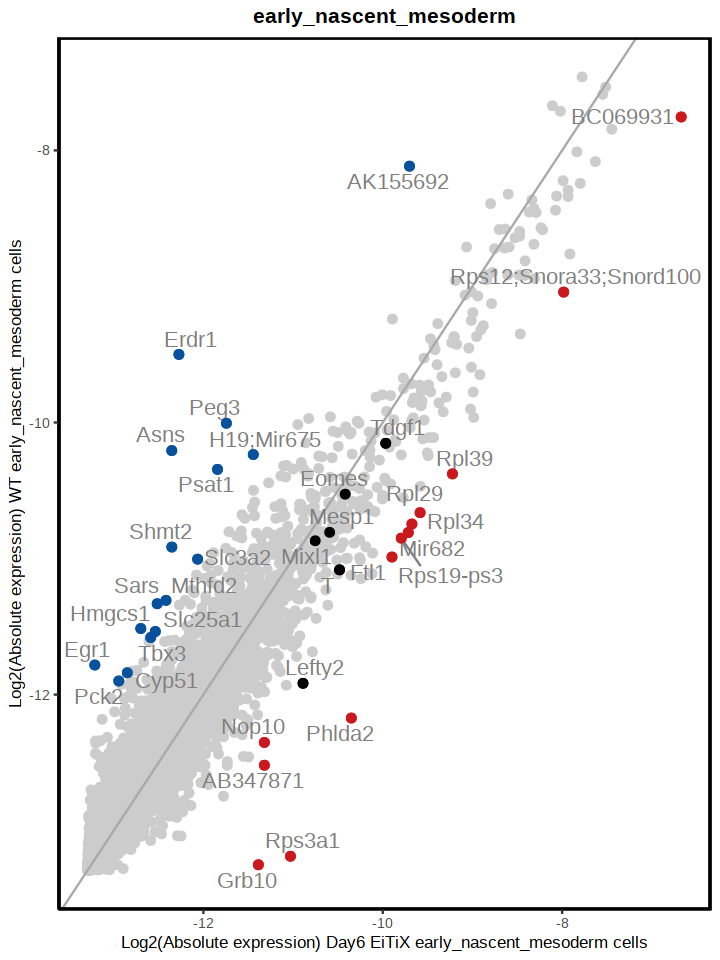

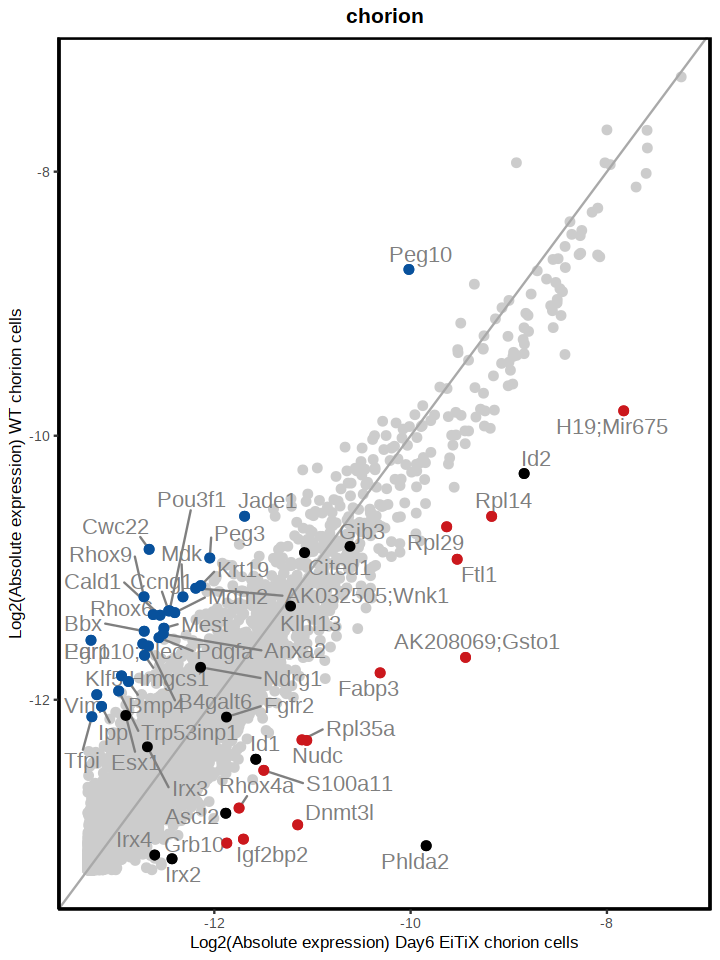

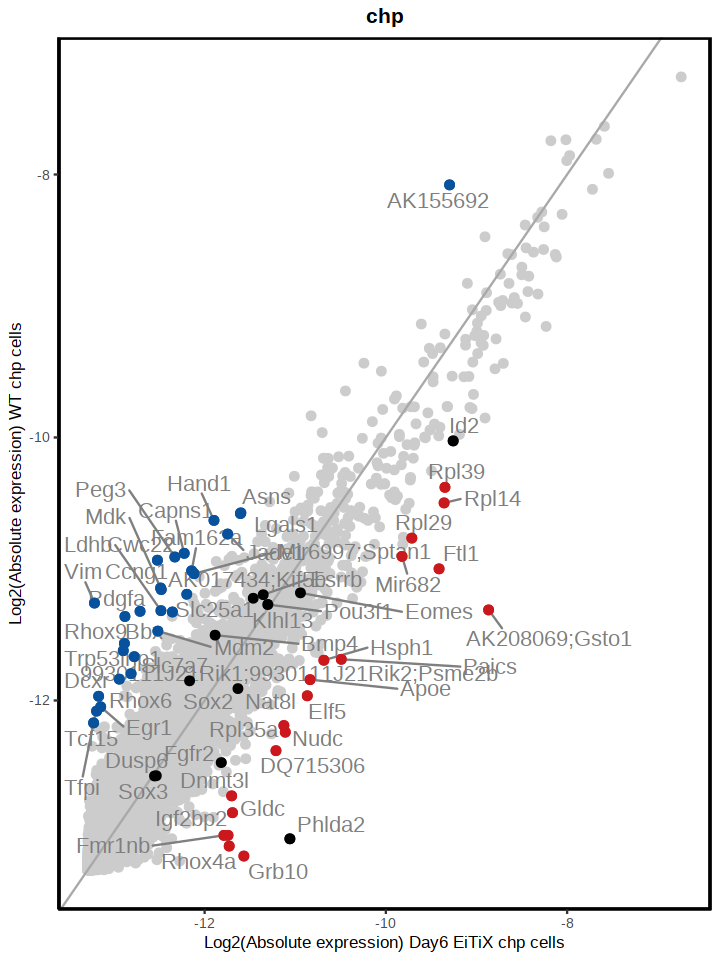

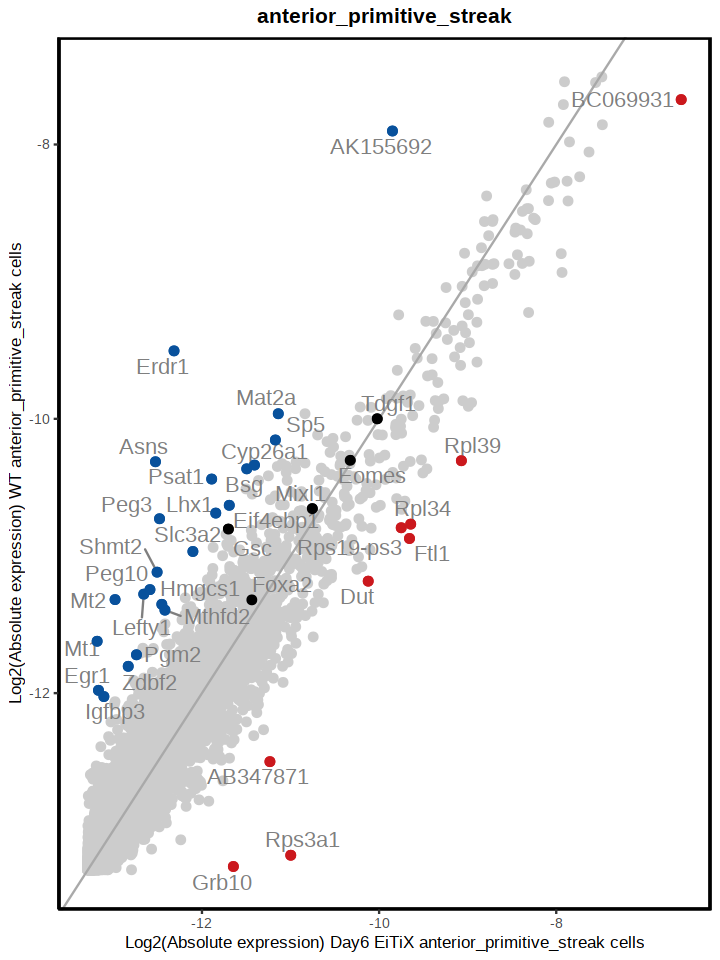

In [21]:
# Day6 DGEs
gmod_chorion <- c(gmod_chorion, "Irx4", "Esx1", "Id1", "Id2", "Phlda2", "Klhl13")
gmod_chp <- c(gmod_chp, "Fgfr2", "Sox3", "Pou3f1", "Id2", "Phlda2", "Klhl13")
gmod_epiblast <- c(gmod_epiblast, "Dnmt3a", "Epcam", "Mycn", "Dnmt3b", "Tet1")
gmod_primitive_streak <- c(gmod_primitive_streak, "Fst", "Trh", "Otx2")
gmod_early_nascent_mesoderm <- c(gmod_early_nascent_mesoderm, "Lefty2")


dge_ct(ct = "epiblast", day = "6", fc = 1)
dge_ct(ct = "primitive_streak", day = "6", fc = 1)
dge_ct(ct = "early_nascent_mesoderm", day = "6", fc = 1)
dge_ct(ct = "chorion", day = "6", fc = 1)
dge_ct(ct = "chp", day = "6", fc = 1)
dge_ct(ct = "anterior_primitive_streak", day = "6", fc = 1)

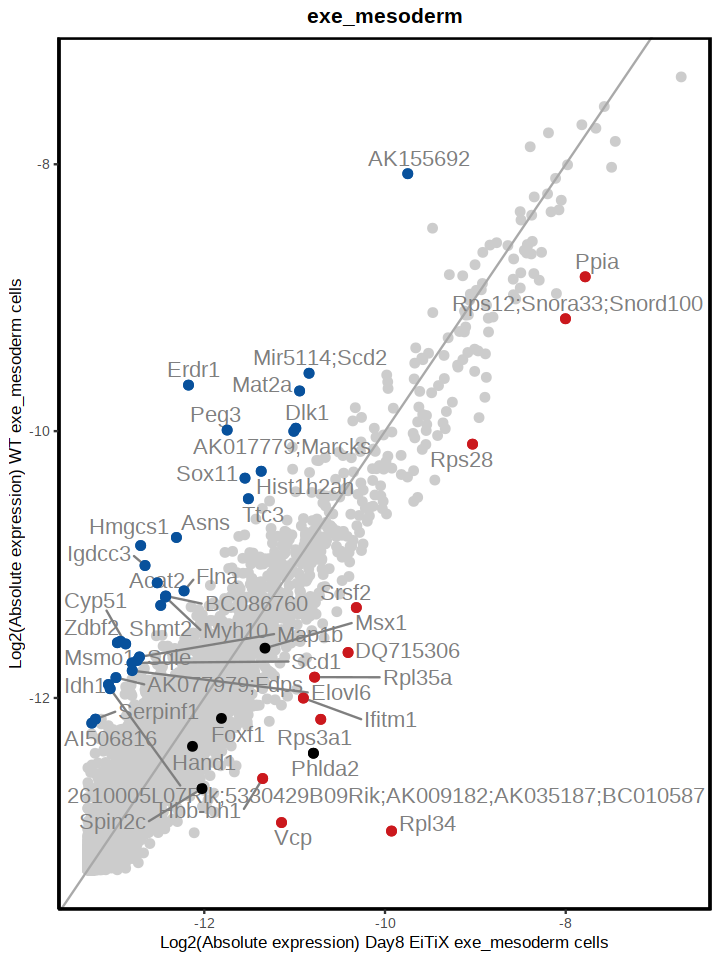

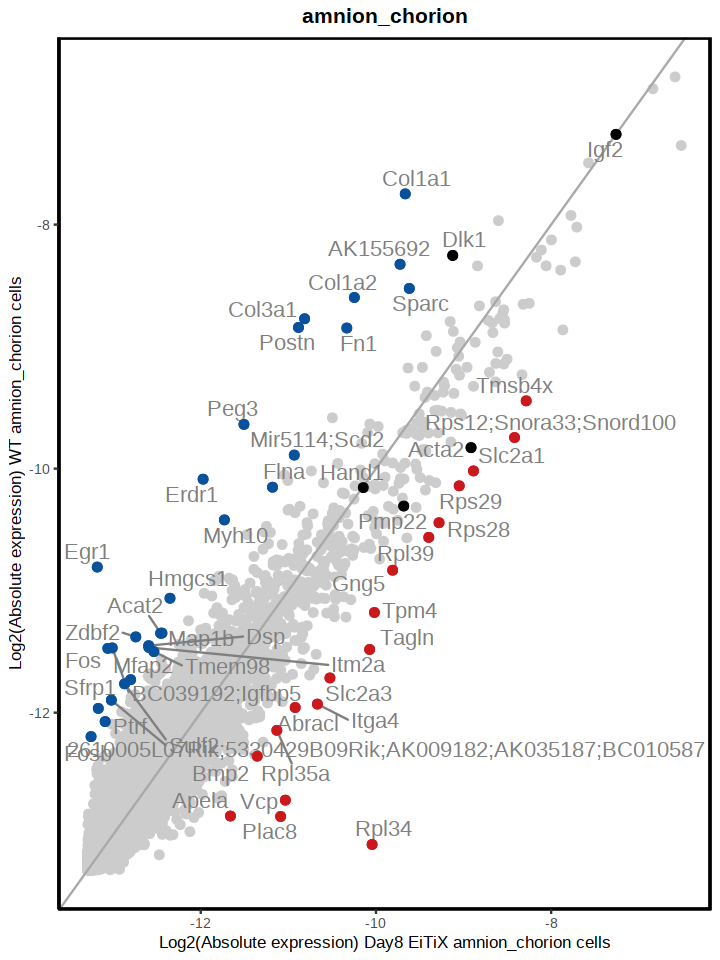

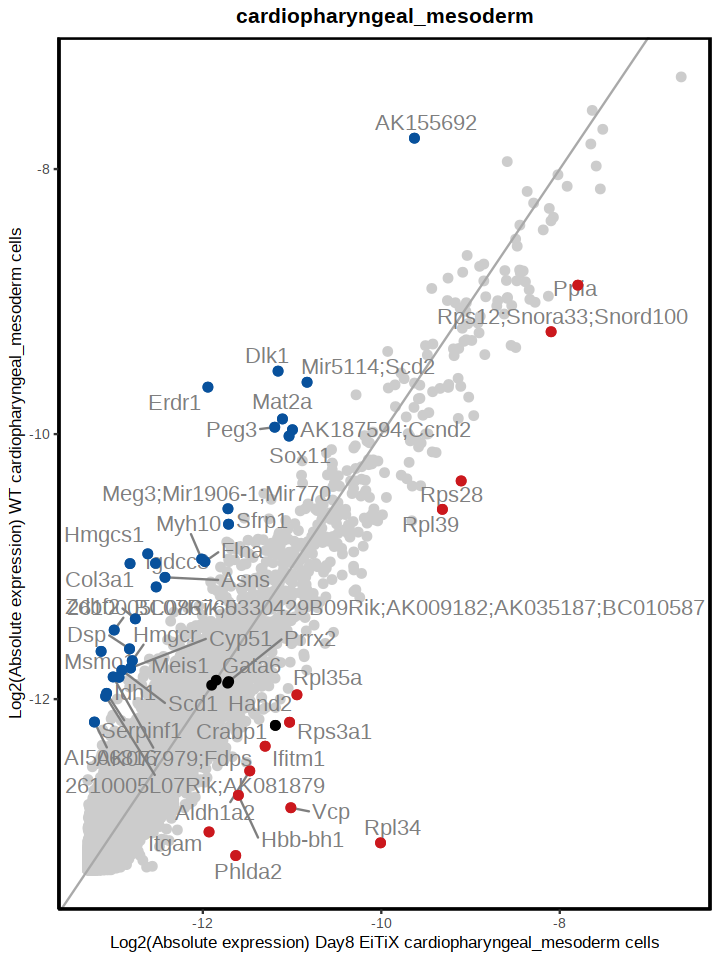

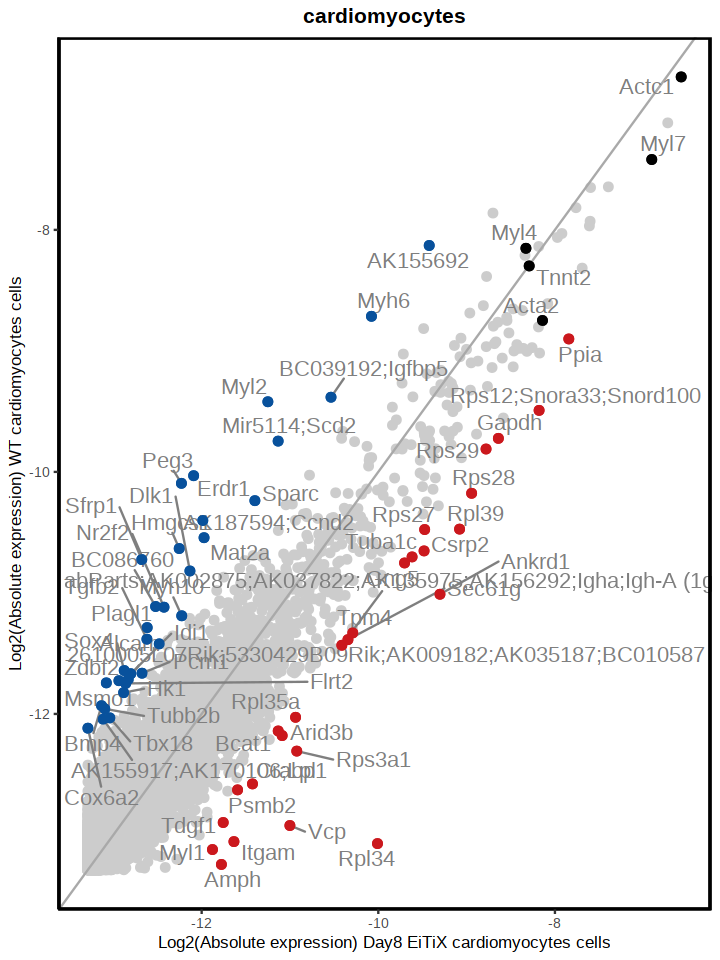

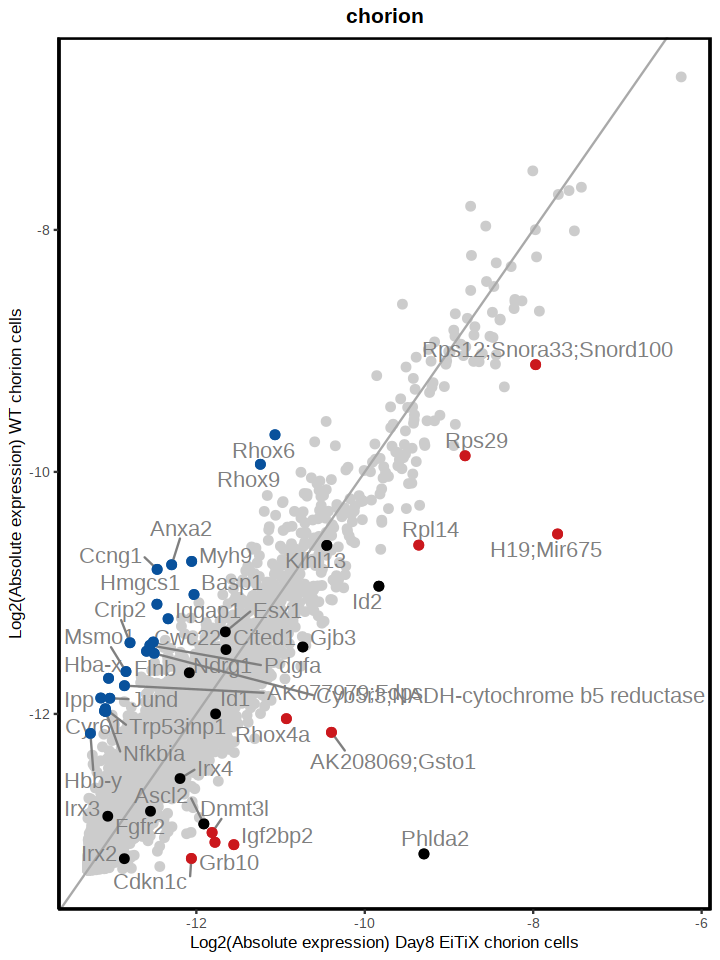

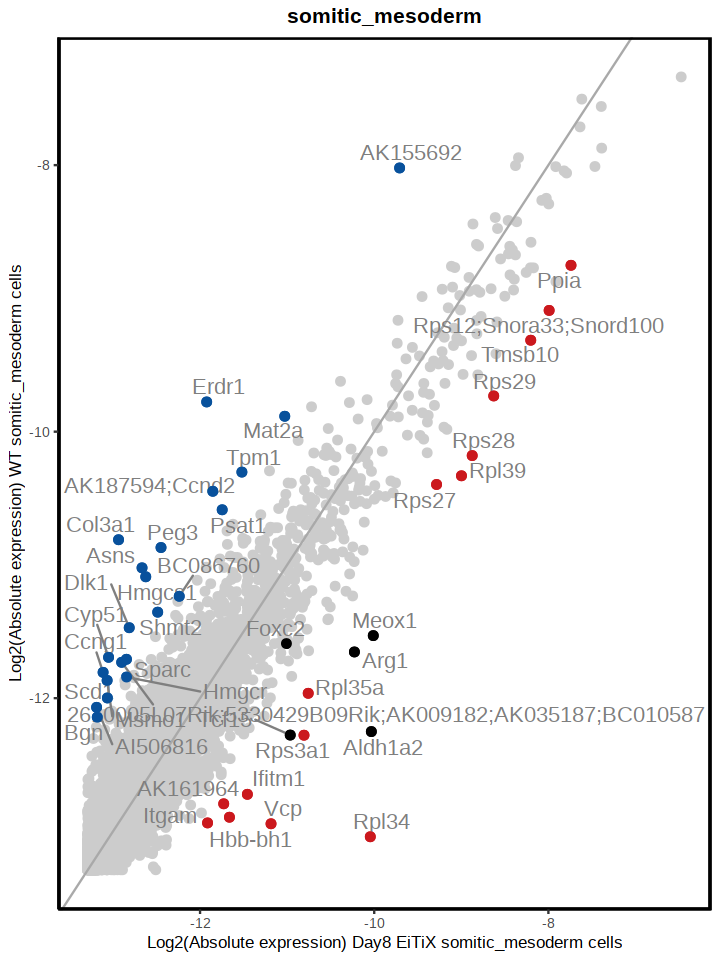

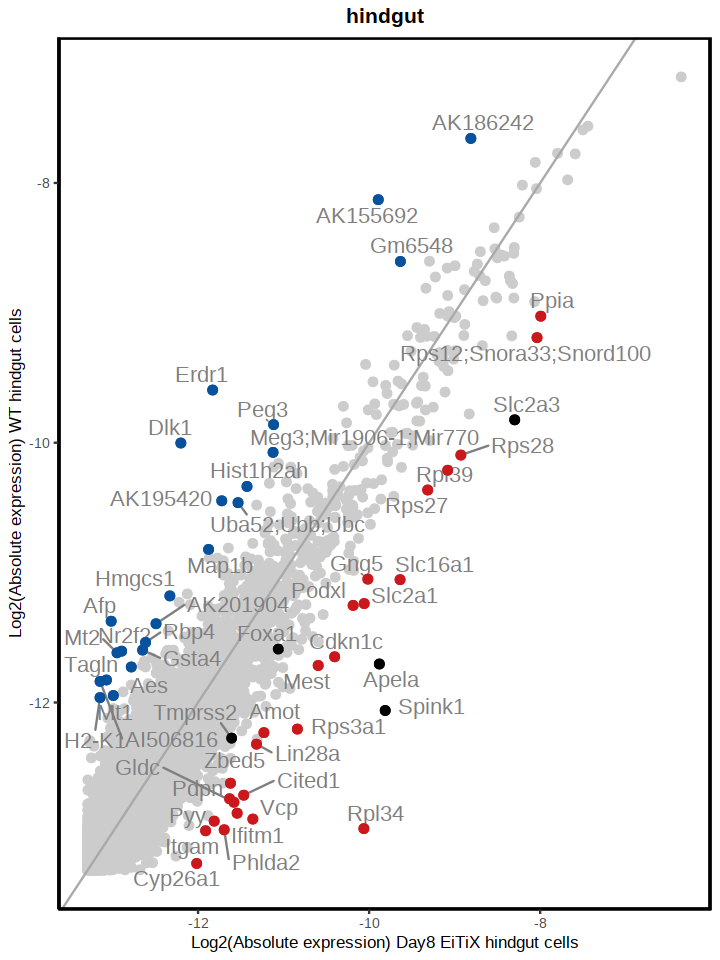

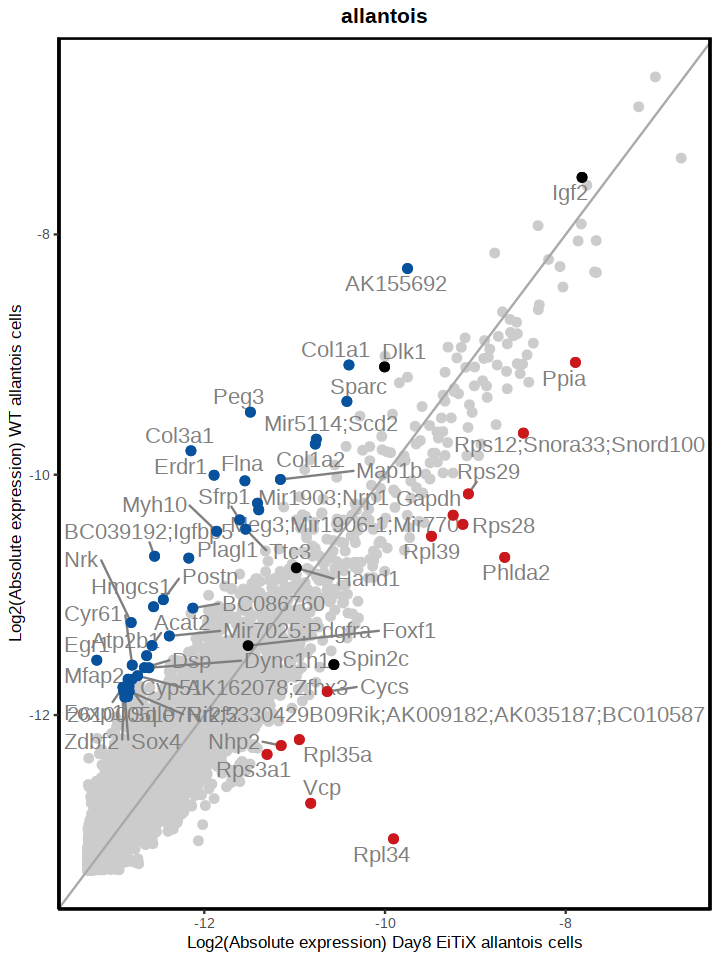

In [22]:
# Day8 DGEs
dge_ct(ct = "exe_mesoderm", day = "8", fc = 1)
dge_ct(ct = "amnion_chorion", day = "8", fc = 1)
dge_ct(ct = "cardiopharyngeal_mesoderm", day = "8", fc = 1)
dge_ct(ct = "cardiomyocytes", day = "8", fc = 1)
dge_ct(ct = "chorion", day = "8", fc = 1)
dge_ct(ct = "somitic_mesoderm", day = "8", fc = 1)
dge_ct(ct = "hindgut", day = "8", fc = 1)
dge_ct(ct = "allantois", day = "8", fc = 1)

### DGEs marked genes

In [23]:
dge_ct_mark <- function(ct, day, fc){
    wt_cels <- get(x = sprintf("%s_cls", ct),envir = .GlobalEnv)
    syn_cels <- get(x = sprintf("%s_synembs", ct),envir = .GlobalEnv)
    day_syn <- get(x = sprintf("synembs_cls_%s", day),envir = .GlobalEnv) 
    day_cls <- get(x = sprintf("matched_cls_%s", day),envir = .GlobalEnv) 
    
    fn <- sprintf("figs/dge_%s_day%s_marked.pdf", ct, day)
    dge1 <- matrix(rowMeans(egc_n[,intersect(wt_cels, day_cls)]),dimnames = list(c(row.names(egc_n))))
    dge2 <- matrix(rowMeans(egc_n[,intersect(syn_cels, day_syn)]),dimnames = list(c(row.names(egc_n))))
    title.nm <- sprintf("%s", ct)

    temp <- cbind(dge2[,1],dge1[,1])
    colnames(temp) <- c("gexp.2", "gexp.1")
    temp <- as.data.frame(temp)
    temp$log.2 <- log2(temp$gexp.2 + 1e-4)
    temp$log.1 <- log2(temp$gexp.1 + 1e-4)
    temp$diff.2 <- log2(temp$gexp.2 + 1e-4) - log2(temp$gexp.1 + 1e-4)
    temp$diff.1 <- log2(temp$gexp.1 + 1e-4) - log2(temp$gexp.2 + 1e-4)

    up <- rownames(temp)[temp$diff.1 > fc]
    dn <- rownames(temp)[temp$diff.2 > fc]
    mark <- get(x = sprintf("gmod_%s", ct),envir = .GlobalEnv)

    rnms <- rownames(temp)
    rnms <- subset(rnms , rnms %in% c(mark))

    temp$log <- NA
    temp$log[rownames(temp) %in% dn] <- "dn"
    temp$log[rownames(temp) %in% up] <- "up"
    temp$log[rownames(temp) %in% mark] <- "mark"
    temp$log[which(is.na(temp$log))] <- "n"


    pa <- ggplot(data = temp,aes(log.1,log.2,col=log)) +
      geom_point(size = 2) +
      geom_abline(slope = 1,col="darkgrey") +
    geom_abline(slope = 1,intercept = 1, col = "gray70",linetype = 'dashed') +
      geom_abline(slope = 1,intercept = -1, col = "gray70",linetype = 'dashed') +      
    ggtitle(title.nm) +
      xlab(sprintf("Log2(Absolute expression) Day%s EiTiX %s cells", day,ct)) +
      ylab(sprintf("Log2(Absolute expression) WT %s cells", ct)) +
        theme(plot.title = element_text(face = "bold",hjust = 0.5)) +

      scale_color_manual(values = c("up"=RColorBrewer::brewer.pal(9,"Reds")[7],
                                    "dn"=RColorBrewer::brewer.pal(9,"Blues")[8],
                                    "mark"="black",
                                    "n"="#CCCCCC"))

    p1 <- pa  + geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                                max.overlaps = 50,
                                aes(log.1,
                                    log.2,
                                    label=rnms, 
                                    col  = "#000000",
                                    size = 10)) +
    
    geom_point(data=subset(temp, rownames(temp) %in% rnms),
                         aes(log.1,log.2), size = 2) +


                theme(legend.position = "none", text = element_text(size = 10),
                    panel.border = element_rect(fill=NA, size = 1))

    p1
    
}

## Fig3g+j and FigS3d

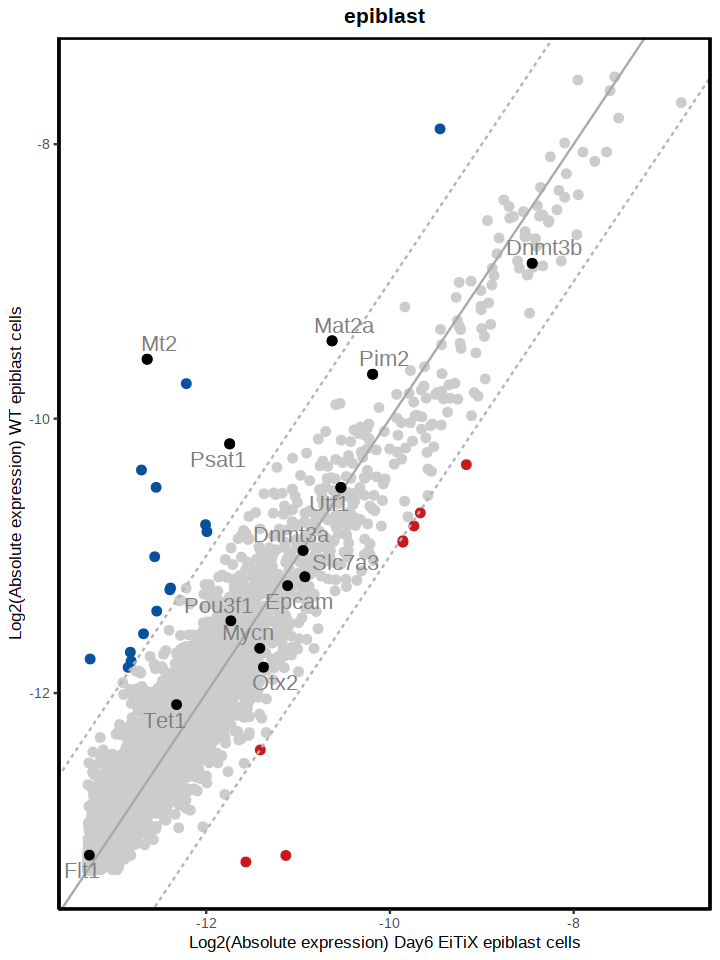

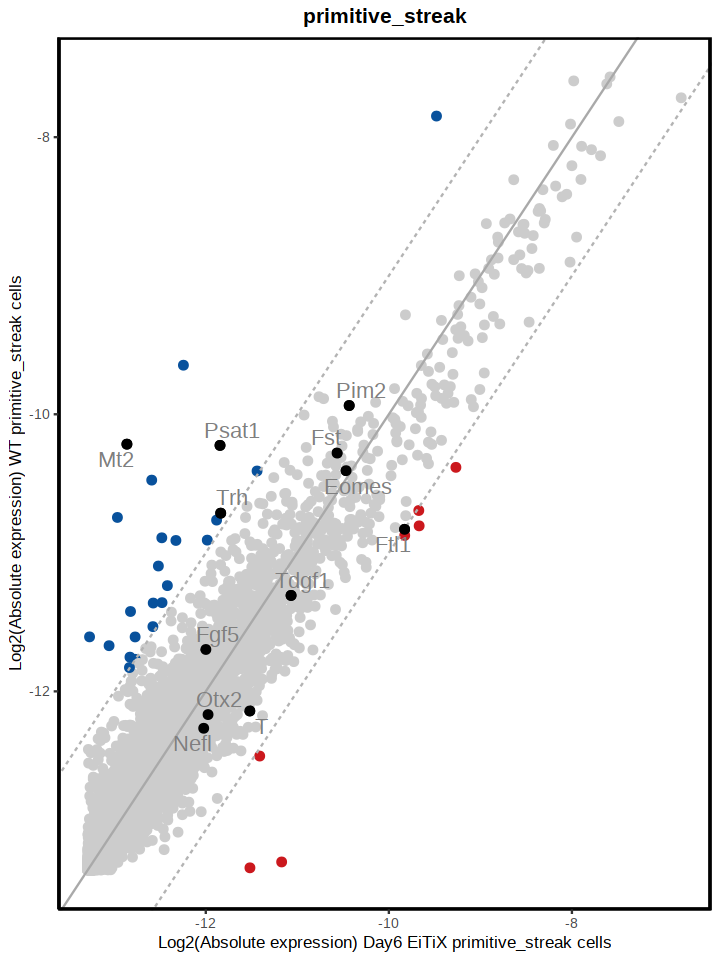

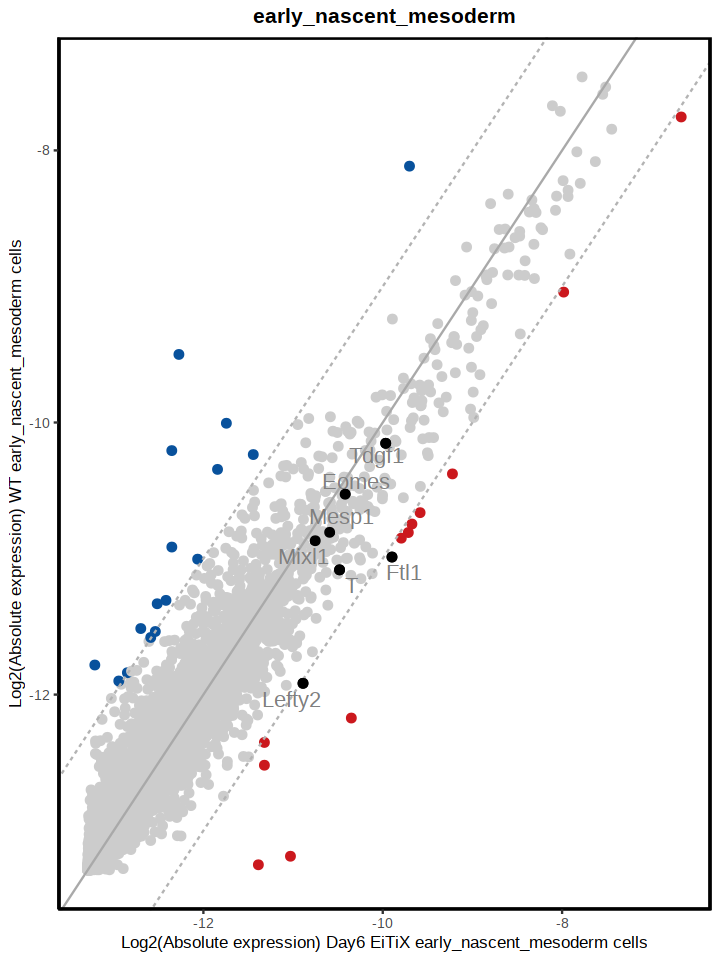

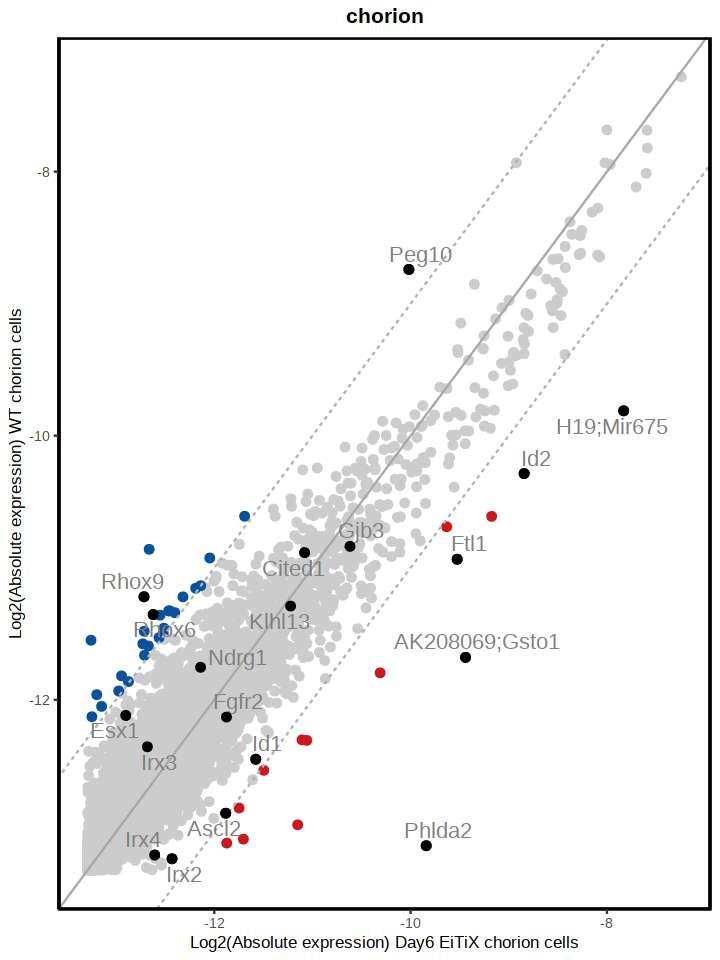

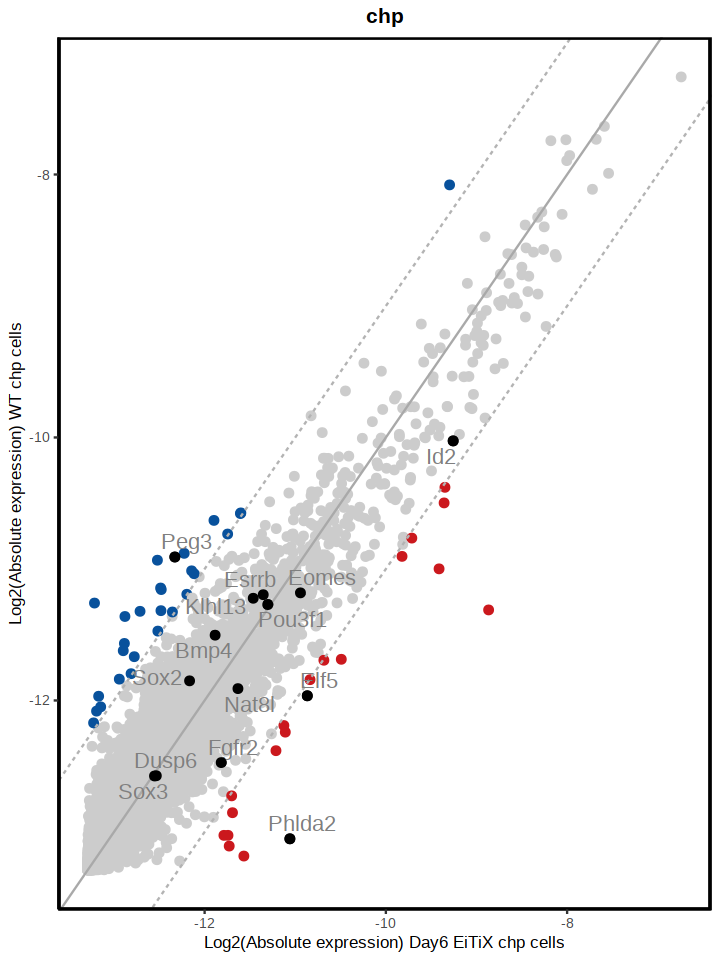

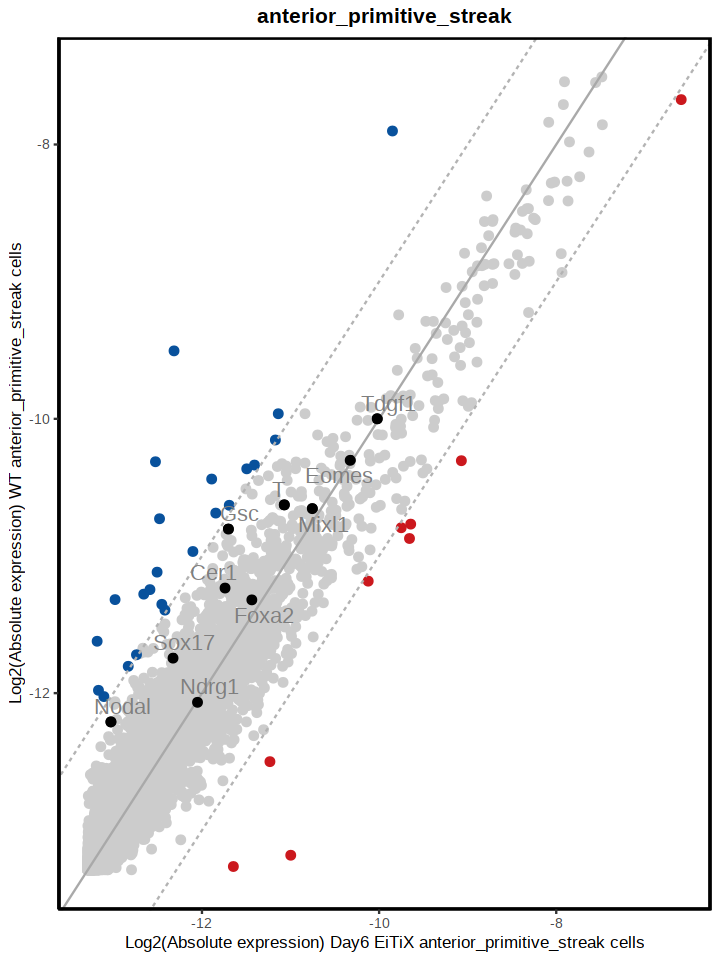

In [24]:
# Day6
gmod_chorion <- c(gmod_chorion, "Peg10", "H19;Mir675", "Rhox9", "Rhox6", "Ftl1", "AK208069;Gsto1")
gmod_chp <- c(gmod_chp, "Elf5", "Peg3", "Pou3f1", "Id2", "Phlda2", "Klhl13")
gmod_epiblast <- c(gmod_epiblast, "Flt1", "Mt2", "Mat2a", "Psat1")
gmod_primitive_streak <- c(gmod_primitive_streak, "Ftl1", "Mt2", "Psat1")
gmod_early_nascent_mesoderm <- c(gmod_early_nascent_mesoderm, "Ftl1")
gmod_anterior_primitive_streak <- c(gmod_anterior_primitive_streak, "Ndrg1", "T", "Cer1", "Sox17", "Nodal")

dge_ct_mark(ct = "epiblast", day = "6", fc = 1)
dge_ct_mark(ct = "primitive_streak", day = "6", fc = 1)
dge_ct_mark(ct = "early_nascent_mesoderm", day = "6", fc = 1)
dge_ct_mark(ct = "chorion", day = "6", fc = 1)
dge_ct_mark(ct = "chp", day = "6", fc = 1)
dge_ct_mark(ct = "anterior_primitive_streak", day = "6", fc = 1)

## Fig5e+h and FigS4b

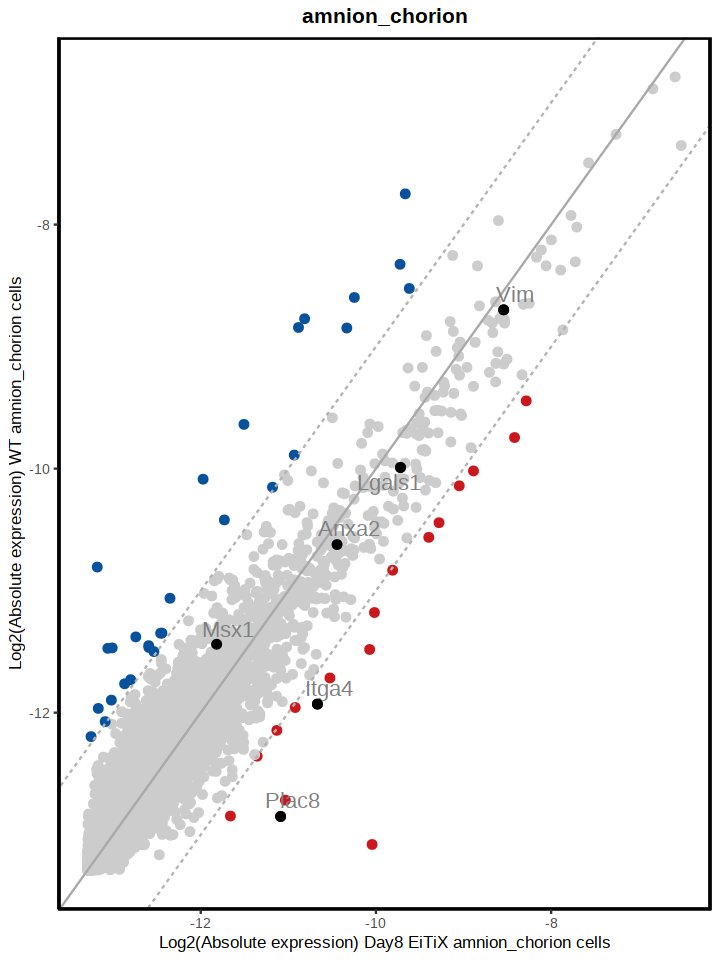

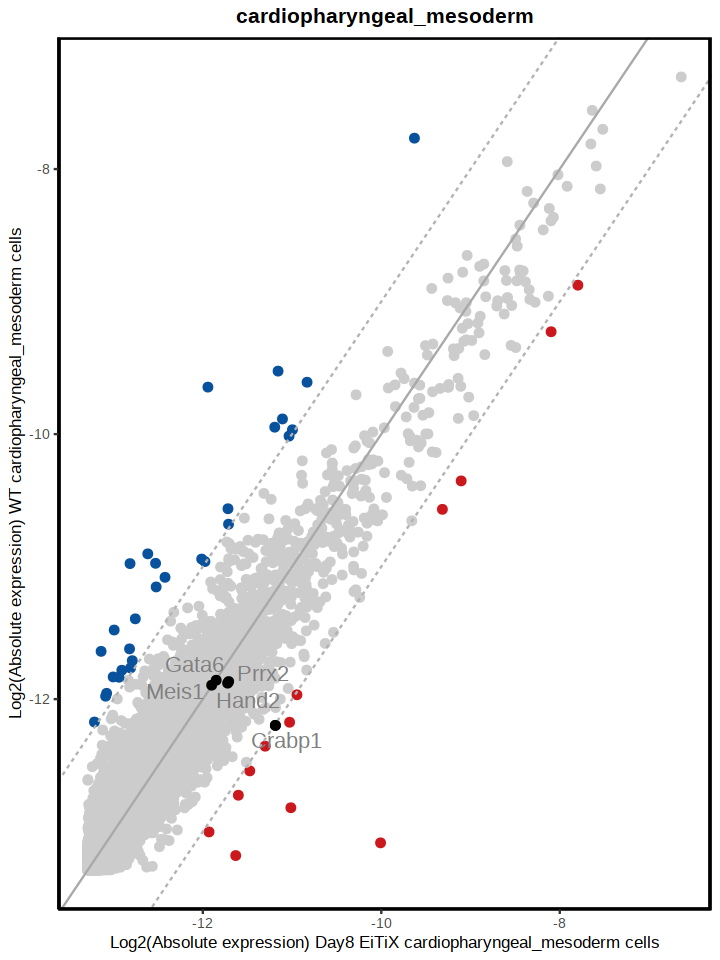

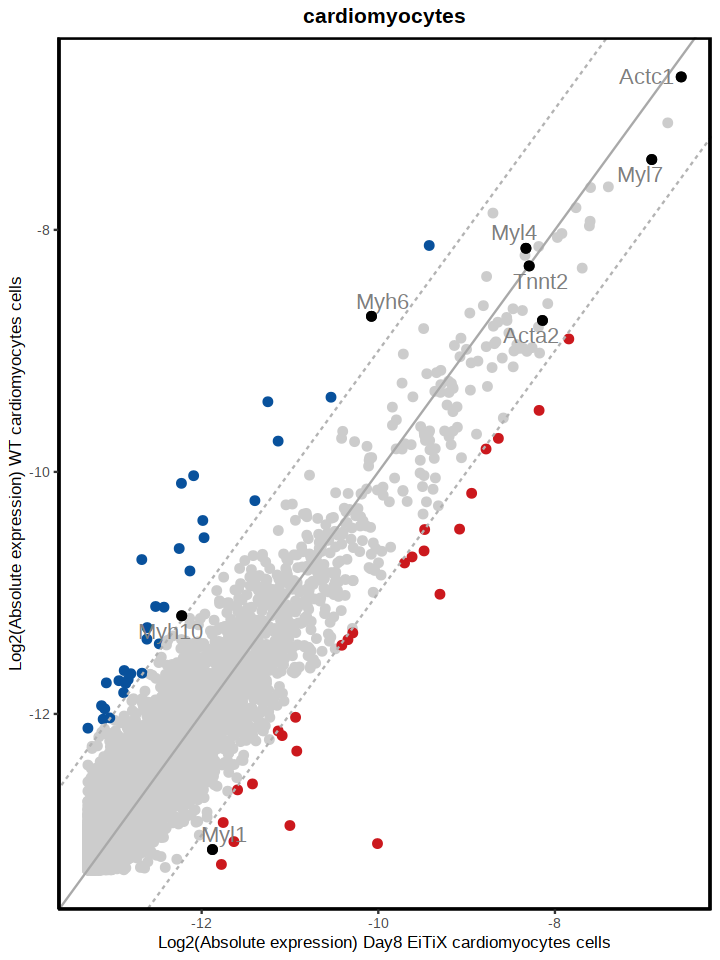

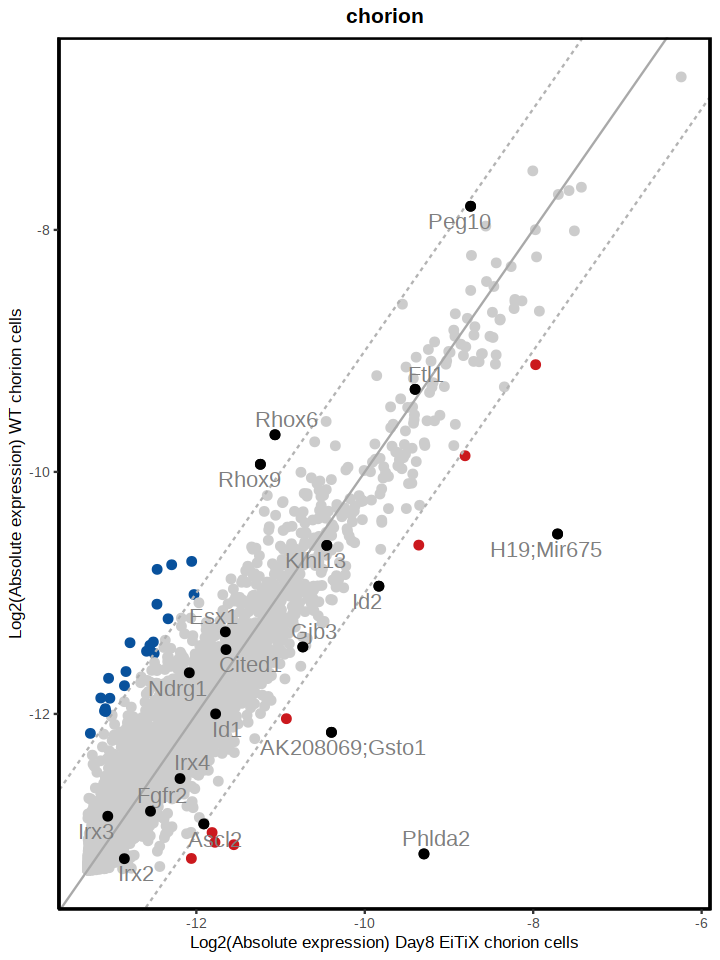

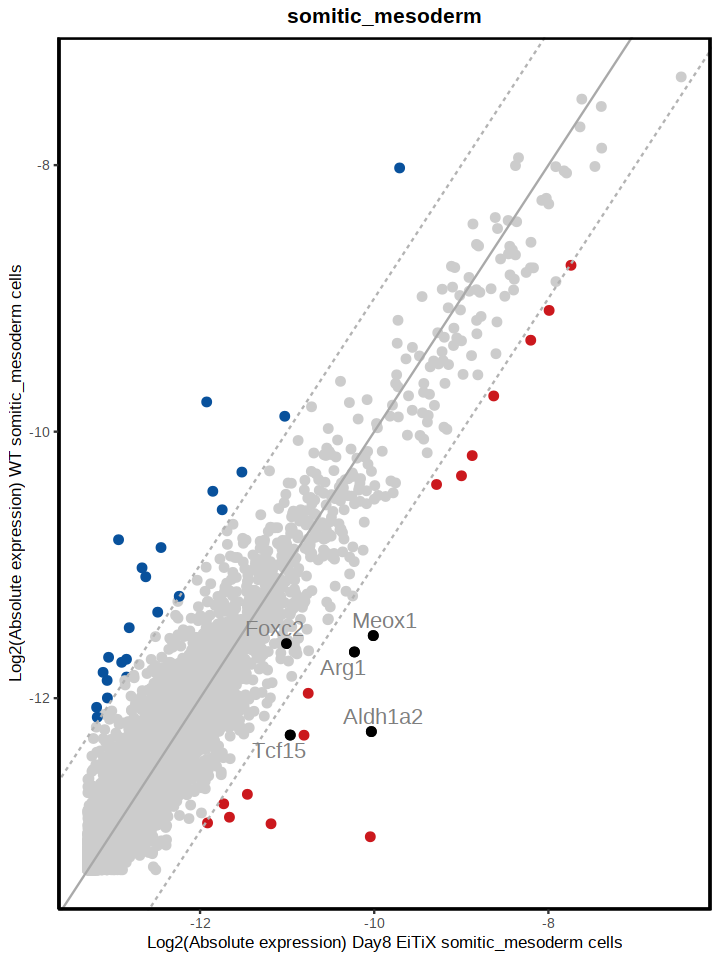

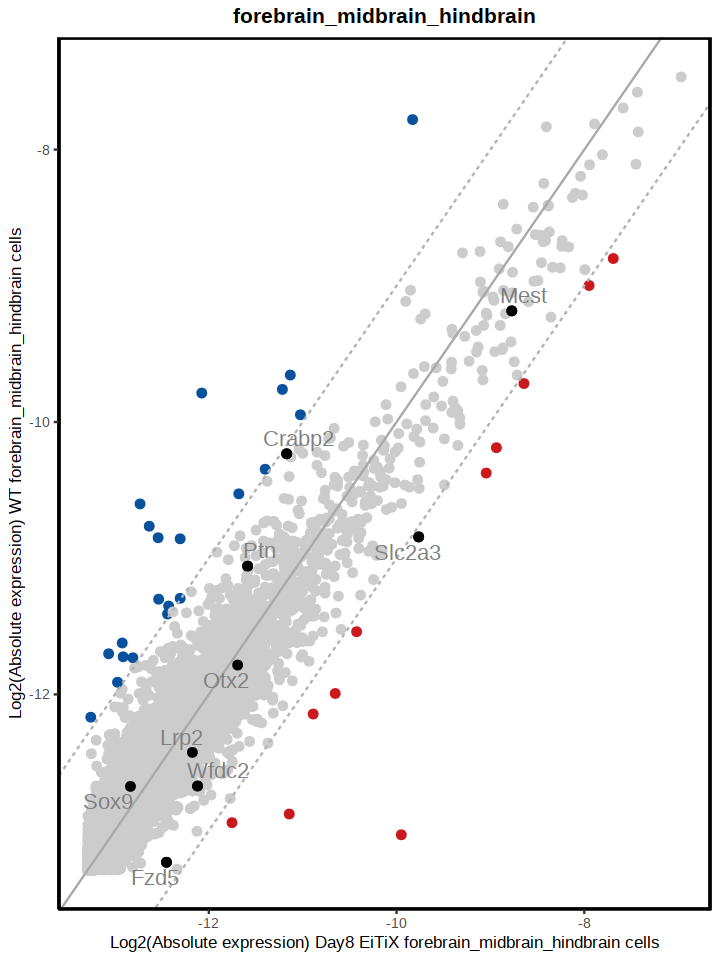

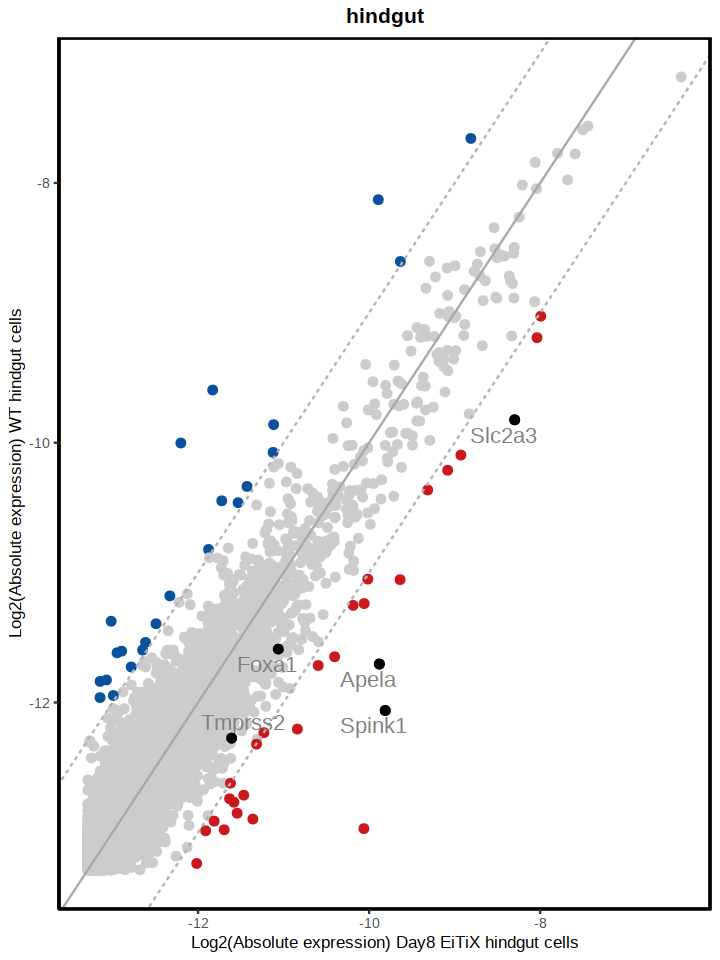

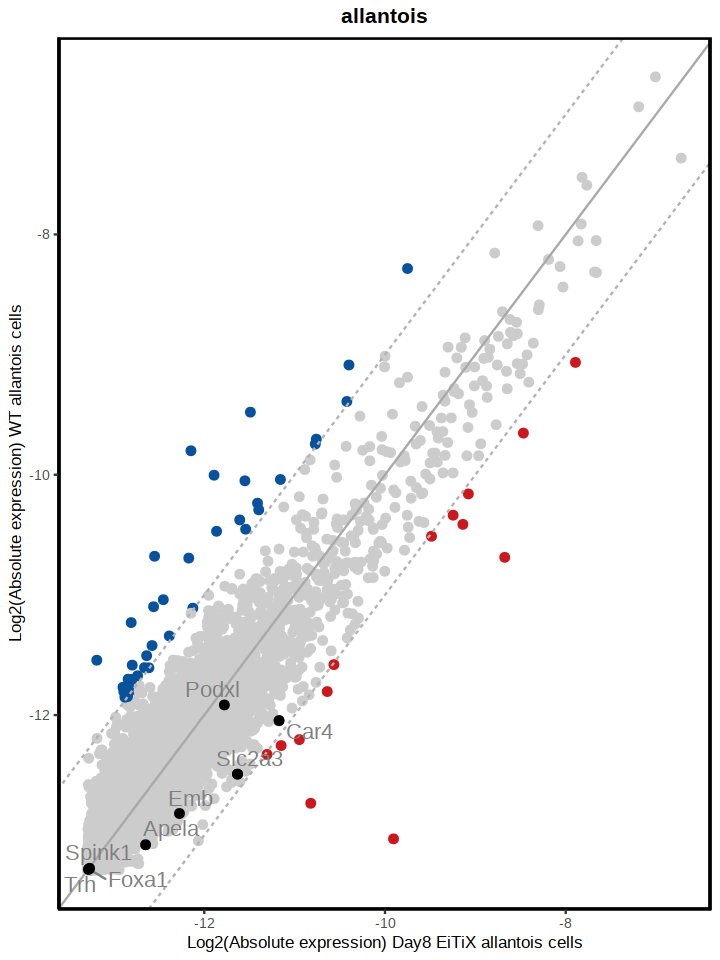

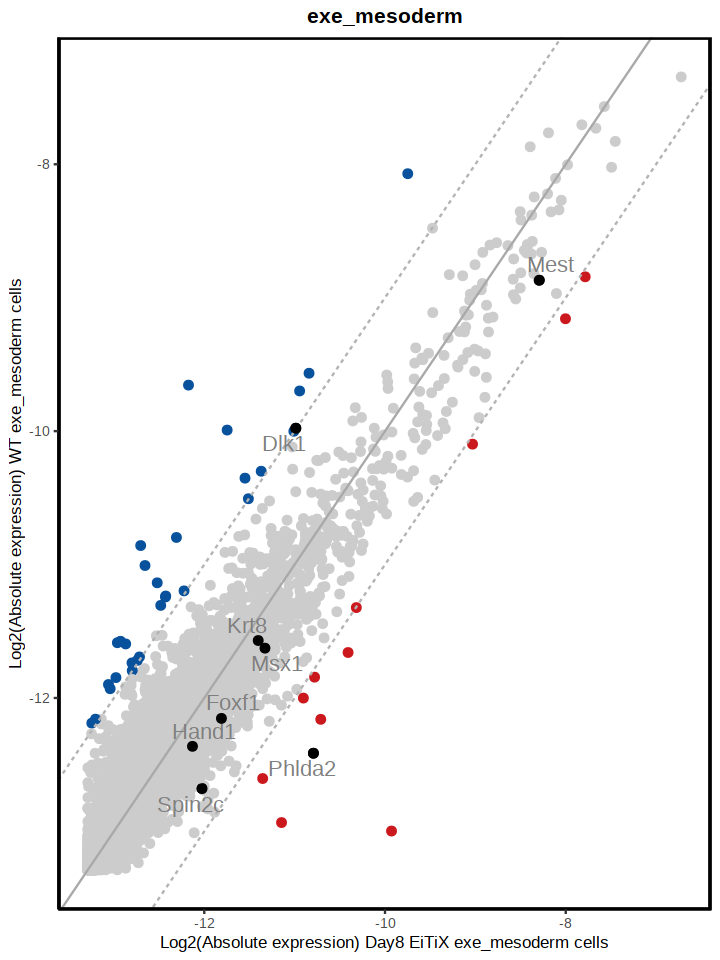

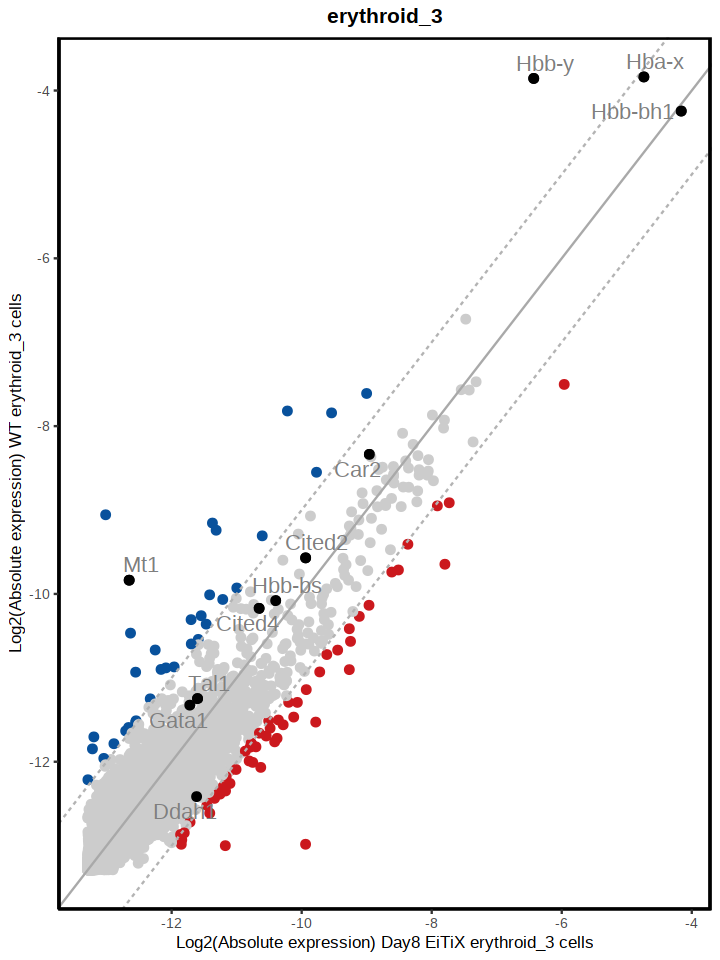

In [25]:
# Day8
gmod_chorion <- c(gmod_chorion,"Rhox6", "Rhox9","Id2")
gmod_amnion_chorion <- c("Vim", "Plac8", "Msx1", "Lgals1", "Itga4", "Anxa2")
gmod_cardiomyocytes <- c(gmod_cardiomyocytes,"Myl7", "Tnnt2", "Myl4", "Myh6", "Myl1", "Myh10")
gmod_cardiopharyngeal_mesoderm <- c(gmod_cardiopharyngeal_mesoderm,"Hand2", "Gata6")
gmod_forebrain_midbrain_hindbrain <- c("Mest", "Lrp2", "Otx2", "Fzd5", "Crabp2", "Sox9", "Wfdc2", "Slc2a3", "Ptn")
gmod_exe_mesoderm <- c("Hand1", "Phlda2", "Msx1", "Mest", "Krt8", "Dlk1", 'Foxf1', "Spin2c")
gmod_allantois <- c("Peg10", "Amot", "Hand1", "Spin2c", "Msx1", "Dlk1", "Mest", 'Igf2')
gmod_allantois <- c("Car4", "Apela", "Foxa1", "Slc2a3", "Spink1", "Trh", "Podxl", 'Emb')
gmod_erythroid_3 <- unique(c(gmod_erythroid_3,"Car2", "Hbb-y", "Hbb-bs", "Cited2","Ddah1","Mt1"))

dge_ct_mark(ct = "amnion_chorion", day = "8", fc = 1)
dge_ct_mark(ct = "cardiopharyngeal_mesoderm", day = "8", fc = 1)
dge_ct_mark(ct = "cardiomyocytes", day = "8", fc = 1)
dge_ct_mark(ct = "chorion", day = "8", fc = 1)
dge_ct_mark(ct = "somitic_mesoderm", day = "8", fc = 1)
dge_ct_mark(ct = "forebrain_midbrain_hindbrain", day = "8", fc = 1)
dge_ct_mark(ct = "hindgut", day = "8", fc = 1)
dge_ct_mark(ct = "allantois", day = "8", fc = 1)
dge_ct_mark(ct = "exe_mesoderm", day = "8", fc = 1)
dge_ct_mark(ct = "erythroid_3", day = "8", fc = 1)

## Fig3E

In [26]:
compute_two_way_table = function(values_row,values_col,included_levels_row = NULL,included_levels_col = NULL,normalize_rows = F) {
  

  if(length(values_row) != length(values_col)) {
    stop("values_row and values_col don't have the same length")
  }
  
 if(!is.null(included_levels_row)) {
   f= values_row %in% included_levels_row
   values_row = values_row[f]
   values_row = factor(x = values_row,levels = included_levels_row)
   values_col = values_col[f]
 }
  if(!is.null(included_levels_col)) {
    f= values_col %in% included_levels_col
    values_row = values_row[f]
    values_col = values_col[f]
    values_col = factor(x = values_col,levels = included_levels_col)
  }
  row_vs_col_freq = table(values_row,values_col)
  
  if(normalize_rows) {
    row_vs_col_freq = row_vs_col_freq/rowSums(row_vs_col_freq)
  }
  return(row_vs_col_freq)
}

In [27]:
color_key_aggregated <- color_key

# Embryo
color_key_aggregated[c(1,2,3,5,7),2] <- "#90BF75" # Ectoderm + neuro
color_key_aggregated[c(13:21,25),2] <- "#C594BF" # Embryonic Mesoderm
color_key_aggregated[c(23,24,26,27),2] <- "#8870AD" # ExE Mesoderm
color_key_aggregated[c(36:40),2] <- "#ED619F" # Endoderm

# ExE
color_key_aggregated[c(43:44),2] <- "#ffad1e" # Chorion TE
color_key_aggregated[c(46:50),2] <- "#67000d" # EPC

color_key_aggregated <- color_key_aggregated[c(1:40,43:50),]

ct_to_col_new <- color_key_aggregated$color
names(ct_to_col_new) <- color_key_aggregated$cell_type

col_to_ct_new <- c("Ectoderm","Embryonic Mesoderm", "ExE Mesoderm", "Embryonic Endoderm",
                  "Chorionic-lineage", "EPC-lineage")
names(col_to_ct_new) <- c("#90BF75", "#C594BF", "#8870AD", "#ED619F",
                         "#ffad1e", "#67000d")


included_colors = c("#90BF75", "#C594BF", "#8870AD","#ED619F", "#ffad1e", "#67000d")

plot_nm_by_ct <- "figs/stat_embryo_exe.pdf"

In [28]:
aggregated_mc_syn <- mc_synembs@colors[mc_synembs@mc[synembs_cls_6]]
names(aggregated_mc_syn) <- color_key$cell_type[match(aggregated_mc_syn,color_key$color)]
syn_cls_ind <- which(names(aggregated_mc_syn) %in% color_key_aggregated$cell_type)
syn_cls_f <- synembs_cls_6[syn_cls_ind]
aggregated_mc_syn_f <- aggregated_mc_syn[syn_cls_ind]

aggregated_mc_syn_recolored <- array(ct_to_col_new)[match(names(aggregated_mc_syn_f),names(ct_to_col_new))]
names(aggregated_mc_syn_recolored) <- names(aggregated_mc_syn_f)

aggregated_mc_wt <- mc_wt@colors[mc_wt@mc[matched_cls_6]]
names(aggregated_mc_wt) <- color_key$cell_type[match(aggregated_mc_wt,color_key$color)]
wt_cls_ind <- which(names(aggregated_mc_wt) %in% color_key_aggregated$cell_type)
wt_cls_f <- matched_cls_6[wt_cls_ind]
aggregated_mc_wt_f <- aggregated_mc_wt[wt_cls_ind]

aggregated_mc_wt_recolored <- array(ct_to_col_new)[match(names(aggregated_mc_wt_f),names(ct_to_col_new))]
names(aggregated_mc_wt_recolored) <- names(aggregated_mc_wt_f)

query_cells_color = aggregated_mc_syn_recolored
names(query_cells_color) <- syn_cls_f
query_cells_final = names(query_cells_color) 

# down sample
tot_cell_count_synembs <- length(syn_cls_f)
set.seed(333)
cls_f = sample(wt_cls_f, size = tot_cell_count_synembs)
dn_smp_ind <- match(cls_f, matched_cls_6)
aggregated_mc_wt_recolored_dnSmpl <- aggregated_mc_wt_recolored[dn_smp_ind]

match_cells_color = aggregated_mc_wt_recolored_dnSmpl
names(match_cells_color) <- cls_f
match_cells_final = names(match_cells_color)

syn_emb_vs_ct = compute_two_way_table(values_row = mat_synembs@cell_metadata[query_cells_final,"embryo"],
                                        values_col = query_cells_color[query_cells_final],
                                        included_levels_row = NULL,
                                        included_levels_col = unique(included_colors),
                                        normalize_rows = T)

match_emb_vs_ct = compute_two_way_table(values_row = mat_wt@cell_metadata[match_cells_final,"embryo"],
                                     values_col = match_cells_color[match_cells_final],
                                     included_levels_row = NULL,
                                     included_levels_col = unique(included_colors),
                                     normalize_rows = T)

query_freq = list(wt = match_emb_vs_ct, query = syn_emb_vs_ct)
query_freq_n = query_freq$query
wt_freq_n = query_freq$wt

Warning message in wilcox.test.default(x = query_freq_n[intersect(rownames(query_freq_n), :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = query_freq_n[intersect(rownames(query_freq_n), :
"cannot compute exact p-value with ties"
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



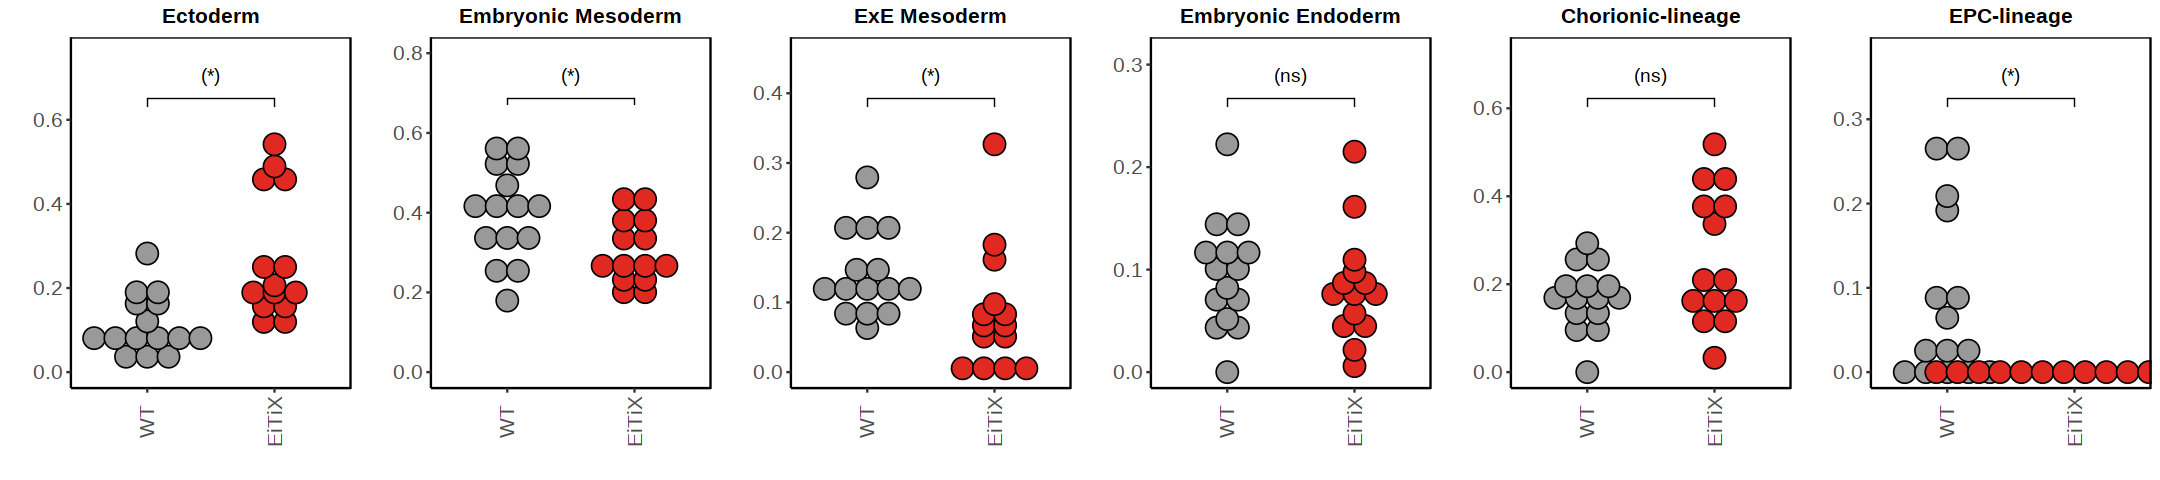

In [29]:
query_to_wt_p_values_6 <- c()

for(ct_col in included_colors){
    p6 <- wilcox.test(x = query_freq_n[intersect(rownames(query_freq_n),synemb_embs_6),ct_col],
                          y = wt_freq_n[intersect(rownames(wt_freq_n),matched_embs_dist_6),ct_col], 
        alternative = "two.sided")$p.value
    
    query_to_wt_p_values_6 <- c(query_to_wt_p_values_6, p6)
}

names(query_to_wt_p_values_6) <- included_colors

q_val_syn_6 = qvalue(p = query_to_wt_p_values_6, pi0 = 1)

stat_comparison = data.frame(group1 = c(rep("WT",length(included_colors))),
           group2 = c(rep("EiTiX",length(included_colors))),
           cell_type = c(col_to_ct_new[names(q_val_syn_6$qvalues)]),
           cell_type_color = c(names(q_val_syn_6$qvalues)),
           q.val = c(q_val_syn_6$qvalues))

stat_comparison$q.signif <- sapply(stat_comparison$q.val,function(x) {
                if(is.na(x)) {a = "NA"} else{if(x >= 0.05) {a = "(ns)"} else {a = "(*)"}}
                return(a)})

genotype_color = c("WT" = "#999999", "EiTiX" = "#E02A21")

match_embs_6_final_count <- sum(rownames(wt_freq_n) %in% matched_embs_dist_6)
match_embs_8_final_count <- sum(rownames(wt_freq_n) %in% matched_embs_dist_8)
syn_embs_6_final_count <- sum(rownames(query_freq_n) %in% synemb_embs_6)
syn_embs_8_final_count <- sum(rownames(query_freq_n) %in% synemb_embs_8)

match_embs_order <- c(rownames(wt_freq_n)[rownames(wt_freq_n) %in% matched_embs_dist_6])
syn_embs_order <- c(rownames(query_freq_n)[rownames(query_freq_n) %in% synemb_embs_6])

plot_list = list()

for (ct_col in included_colors) {
  
    main_tag = array(col_to_ct_new)[names(col_to_ct_new) == ct_col]
  
    df_plot_points = data.frame("genotype" = factor(x = c(rep("EiTiX",syn_embs_6_final_count),
                                                          rep("WT",match_embs_6_final_count)),
                         levels = names(genotype_color)),
       "freq" = c(query_freq_n[syn_embs_order,ct_col],wt_freq_n[match_embs_order,ct_col]))

    stat_f = stat_comparison[stat_comparison$cell_type_color == ct_col,]
  
  
  p = ggplot(data = df_plot_points, aes(x = genotype, y = freq)) +
    geom_dotplot(aes(fill = genotype),dotsize = 2, binaxis = "y", stackdir = "center", show.legend = F) +
    ggpubr::stat_pvalue_manual(stat_f, vjust = -1,
                               y.position = max(df_plot_points$freq)*1.2, 
                               label = "q.signif") +
    scale_fill_manual(values = genotype_color) + 
    ggtitle(label = main_tag) +
    theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 12),
          axis.text.x = element_text(angle = 90, vjust = 0.5, size = 12),
          axis.text.y = element_text(size = 12),
          axis.title = element_text(face = "bold",size = 12),
          panel.grid = element_blank(),
          panel.border = element_rect(fill=NA),
          legend.position="None") + 
    ylab("") + 
    ylim(0,max(df_plot_points$freq)*1.4) +
    xlab("") 
  
  plot_list[[ct_col]] = p
}

options(repr.plot.width=18, repr.plot.height=4)
p_all =  gridExtra::grid.arrange(grobs = plot_list, ncol = length(included_colors), nrow = 1)

## FigS3b

Completed



png 
  2

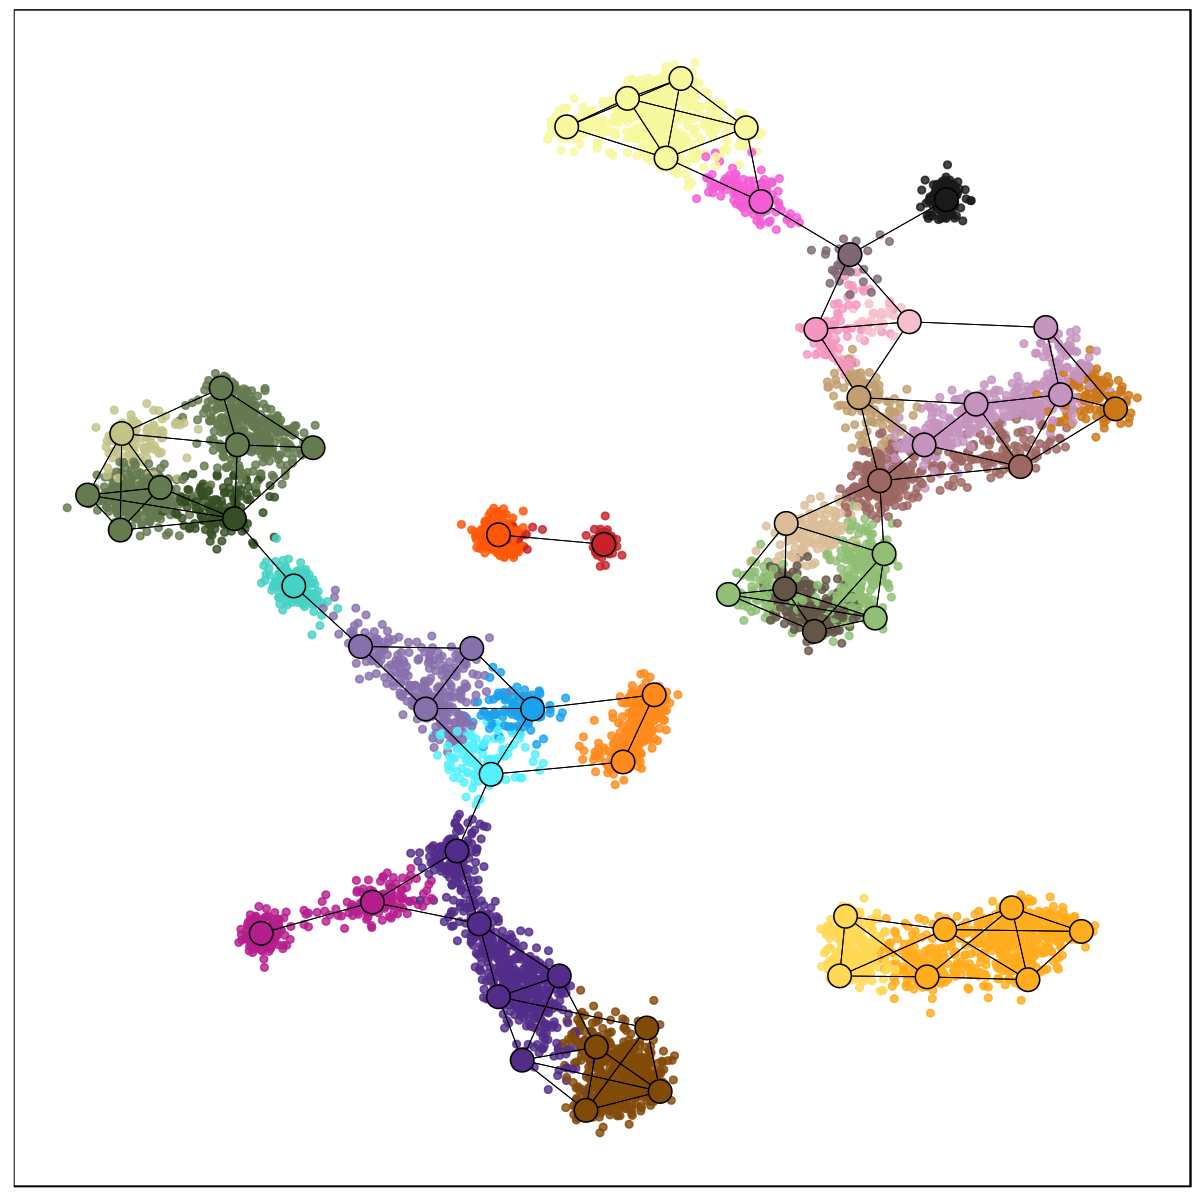

In [30]:
## Day6+8 combined 2d manifold 
source("scripts/manifold_2d_proj_hr.R")
options(repr.plot.width=10, repr.plot.height=10)
manifold2dproj_hr(mc2d_id = "SynEmb3_old",
                  mc_id = "SynEmb3_recolored_old",
                  plot_mc = T,
                  sc_point_size = 1.5,
                  sc_transparency = 0.8,
                  mc_name_txt_size = 0,
                  mc_point_size = 6,
                  studio_plot = T)

In [31]:
source("scripts/atlas_proj-Copy1.r")

In [32]:
exe_mcs <- which(mc_synembs@colors %in% exe_cols)
emb_mcs <- which(mc_synembs@colors %in% emb_cols)

exe_cls <- names(mc_synembs@mc)[as.numeric(mc_synembs@mc) %in% exe_mcs]
emb_cls <- names(mc_synembs@mc)[as.numeric(mc_synembs@mc) %in% emb_mcs]

exe_cls_day6 <- exe_cls[exe_cls %in% synembs_cls_6]
exe_cls_day8 <- exe_cls[exe_cls %in% synembs_cls_8]

emb_cls_day6 <- emb_cls[emb_cls %in% synembs_cls_6]
emb_cls_day8 <- emb_cls[emb_cls %in% synembs_cls_8]

In [33]:
best_reference_emb <- project_query_mc_egc_on_reference_mc_egc(egc_query = mc_synembs@e_gc[,emb_mcs], 
                                                                    egc_reference = mc_wt_emb@e_gc,
                                                                    reg = 1e-5)

best_reference_exe <- project_query_mc_egc_on_reference_mc_egc(egc_query = mc_synembs@e_gc[,exe_mcs], 
                                                                    egc_reference = mc_wt_exe@e_gc,
                                                                    reg = 1e-5)

## Pooled projection of exe day6

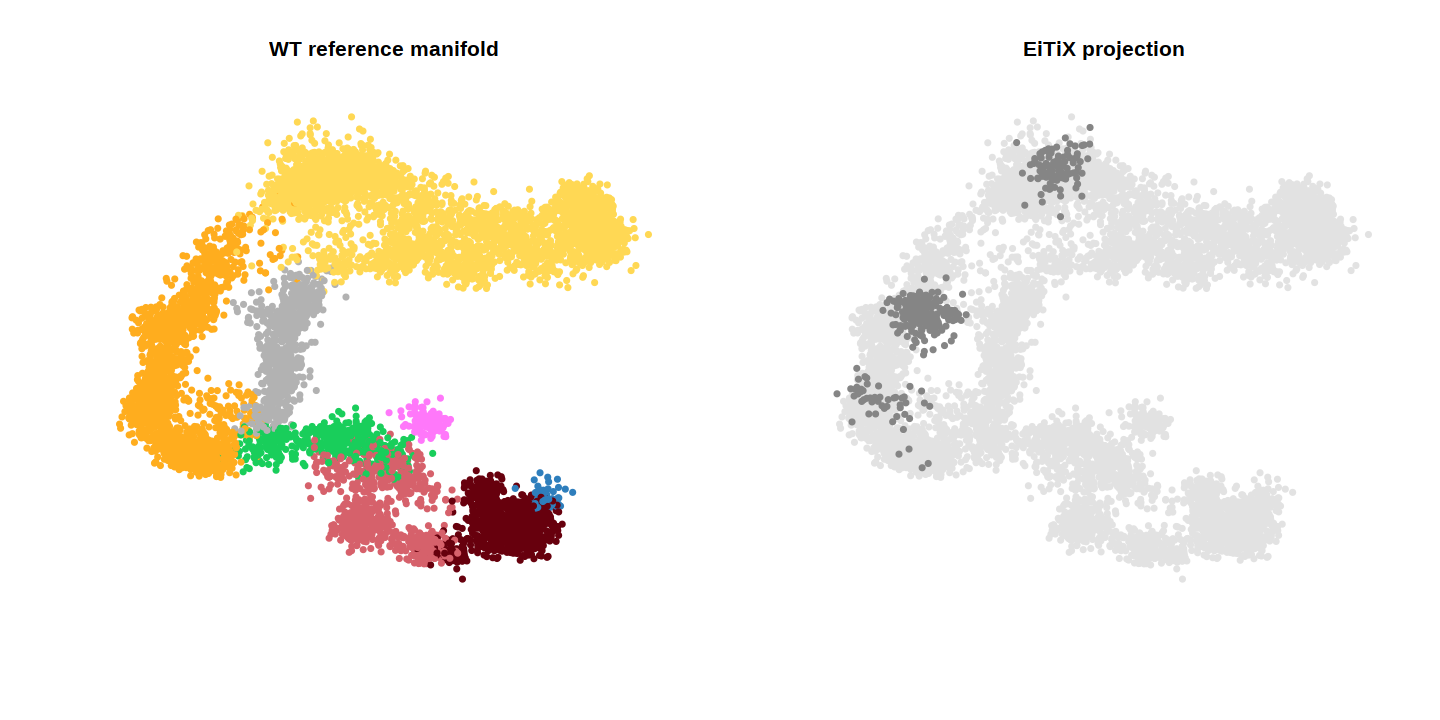

In [34]:
mc2d_wt = scdb_mc2d("exe")

atlas_cells_background_color = rep("#E2E2E2",length(mc2d_wt@sc_x))
names(atlas_cells_background_color) = names(mc2d_wt@sc_x)

query_mcs_vector <- as.numeric(mc_synembs@mc[names(mc_synembs@mc) %in% exe_cls_day6])

best_reference_metacell <- as.numeric(best_reference_exe$best_reference_metacell)[match(query_mcs_vector,names(best_reference_exe$best_reference_metacell))]
names(best_reference_metacell) <- query_mcs_vector

n = length(best_reference_metacell)

mcs <- unique(as.numeric(best_reference_metacell))

xrange = 0.03 * (max(mc2d_wt@mc_x) - min(mc2d_wt@mc_x))
yrange = 0.03 * (max(mc2d_wt@mc_y) - min(mc2d_wt@mc_y))

ref_x = mc2d_wt@mc_x[best_reference_metacell] + rnorm(n, 0, xrange)
ref_y = mc2d_wt@mc_y[best_reference_metacell] + rnorm(n, 0, yrange)

xlim = c(min(mc2d_wt@mc_x), max(mc2d_wt@mc_x))
ylim = c(min(mc2d_wt@mc_y), max(mc2d_wt@mc_y))

f = !is.na(mc2d_wt@sc_x)
all_cells = names(mc2d_wt@sc_x)[f]

cex.points = 0.5
cex.main = 1

# pdf("figs/exe_manifolds_wt_vs_EiTiX_day6.pdf", width = 12, height = 6, useDingbats = F)
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(mc2d_wt@sc_x,
     mc2d_wt@sc_y, 
     col = mc_wt@colors[mc_wt@mc[names(mc2d_wt@sc_x)]],
     pch = 19,cex = cex.points,
     xaxt = 'n',yaxt = 'n',
     xlab = "",ylab = "",
     axes = F,
     main = "WT reference manifold",
     cex.main = cex.main)

plot(mc2d_wt@sc_x[all_cells],mc2d_wt@sc_y[all_cells], 
     col = atlas_cells_background_color[all_cells],
     pch = 19,cex = cex.points,xaxt = 'n',yaxt = 'n',xlab = "",ylab = "",
     axes = F,
     main = "EiTiX projection",
     cex.main = cex.main)

points(ref_x, ref_y, pch = 19, col = "#858585", 
ylim = ylim, xlim = xlim,cex = cex.points)

# dev.off()

## Pooled projection of embryo day6

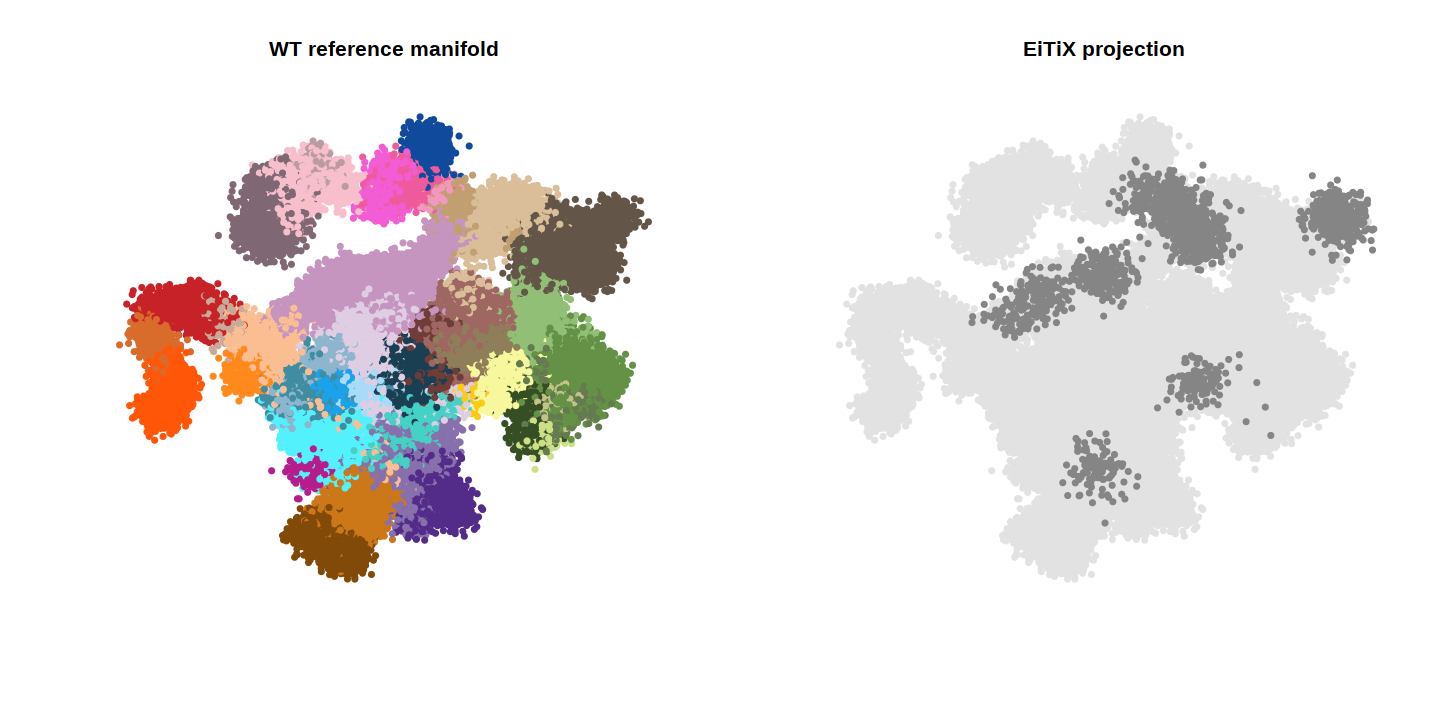

In [35]:
mc2d_wt = scdb_mc2d("emb")

atlas_cells_background_color = rep("#E2E2E2",length(mc2d_wt@sc_x))
names(atlas_cells_background_color) = names(mc2d_wt@sc_x)

query_mcs_vector <- as.numeric(mc_synembs@mc[names(mc_synembs@mc) %in% emb_cls_day6])

best_reference_metacell <- as.numeric(best_reference_emb$best_reference_metacell)[match(query_mcs_vector,names(best_reference_emb$best_reference_metacell))]
names(best_reference_metacell) <- query_mcs_vector

n = length(best_reference_metacell)

mcs <- unique(as.numeric(best_reference_metacell))

xrange = 0.03 * (max(mc2d_wt@mc_x) - min(mc2d_wt@mc_x))
yrange = 0.03 * (max(mc2d_wt@mc_y) - min(mc2d_wt@mc_y))

ref_x = mc2d_wt@mc_x[best_reference_metacell] + rnorm(n, 0, xrange)
ref_y = mc2d_wt@mc_y[best_reference_metacell] + rnorm(n, 0, yrange)

xlim = c(min(mc2d_wt@mc_x), max(mc2d_wt@mc_x))
ylim = c(min(mc2d_wt@mc_y), max(mc2d_wt@mc_y))

f = !is.na(mc2d_wt@sc_x)
all_cells = names(mc2d_wt@sc_x)[f]

cex.points = 0.5
cex.main = 1

# pdf("figs/emb_manifolds_wt_vs_EiTiX_day6.pdf", width = 12, height = 6, useDingbats = F)
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(mc2d_wt@sc_x,
     mc2d_wt@sc_y, 
     col = mc_wt@colors[mc_wt@mc[names(mc2d_wt@sc_x)]],
     pch = 19,cex = cex.points,
     xaxt = 'n',yaxt = 'n',
     xlab = "",ylab = "",
     axes = F,
     main = "WT reference manifold",
     cex.main = cex.main)

plot(mc2d_wt@sc_x[all_cells],mc2d_wt@sc_y[all_cells], 
     col = atlas_cells_background_color[all_cells],
     pch = 19,cex = cex.points,xaxt = 'n',yaxt = 'n',xlab = "",ylab = "",
     axes = F,
     main = "EiTiX projection",
     cex.main = cex.main)

points(ref_x, ref_y, pch = 19, col = "#858585", 
ylim = ylim, xlim = xlim,cex = cex.points)

# dev.off()

## Pooled projection of exe day8

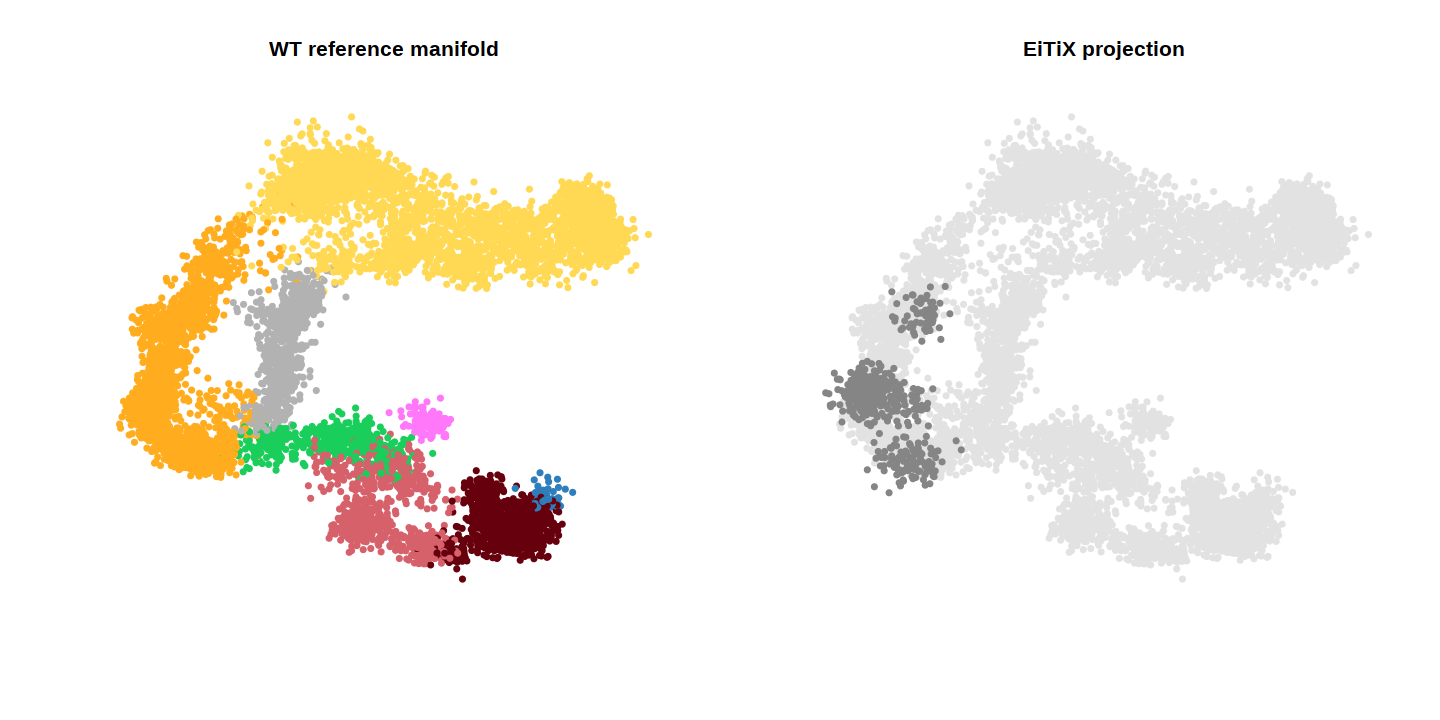

In [36]:
mc2d_wt = scdb_mc2d("exe")

atlas_cells_background_color = rep("#E2E2E2",length(mc2d_wt@sc_x))
names(atlas_cells_background_color) = names(mc2d_wt@sc_x)

query_mcs_vector <- as.numeric(mc_synembs@mc[names(mc_synembs@mc) %in% exe_cls_day8])

best_reference_metacell <- as.numeric(best_reference_exe$best_reference_metacell)[match(query_mcs_vector,names(best_reference_exe$best_reference_metacell))]
names(best_reference_metacell) <- query_mcs_vector

n = length(best_reference_metacell)

mcs <- unique(as.numeric(best_reference_metacell))

xrange = 0.03 * (max(mc2d_wt@mc_x) - min(mc2d_wt@mc_x))
yrange = 0.03 * (max(mc2d_wt@mc_y) - min(mc2d_wt@mc_y))

ref_x = mc2d_wt@mc_x[best_reference_metacell] + rnorm(n, 0, xrange)
ref_y = mc2d_wt@mc_y[best_reference_metacell] + rnorm(n, 0, yrange)

xlim = c(min(mc2d_wt@mc_x), max(mc2d_wt@mc_x))
ylim = c(min(mc2d_wt@mc_y), max(mc2d_wt@mc_y))

f = !is.na(mc2d_wt@sc_x)
all_cells = names(mc2d_wt@sc_x)[f]

cex.points = 0.5
cex.main = 1

# pdf("figs/exe_manifolds_wt_vs_EiTiX_day8.pdf", width = 12, height = 6, useDingbats = F)
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(mc2d_wt@sc_x,
     mc2d_wt@sc_y, 
     col = mc_wt@colors[mc_wt@mc[names(mc2d_wt@sc_x)]],
     pch = 19,cex = cex.points,
     xaxt = 'n',yaxt = 'n',
     xlab = "",ylab = "",
     axes = F,
     main = "WT reference manifold",
     cex.main = cex.main)

plot(mc2d_wt@sc_x[all_cells],mc2d_wt@sc_y[all_cells], 
     col = atlas_cells_background_color[all_cells],
     pch = 19,cex = cex.points,xaxt = 'n',yaxt = 'n',xlab = "",ylab = "",
     axes = F,
     main = "EiTiX projection",
     cex.main = cex.main)

points(ref_x, ref_y, pch = 19, col = "#858585", 
ylim = ylim, xlim = xlim,cex = cex.points)

# dev.off()

## Pooled projection of embryo day8

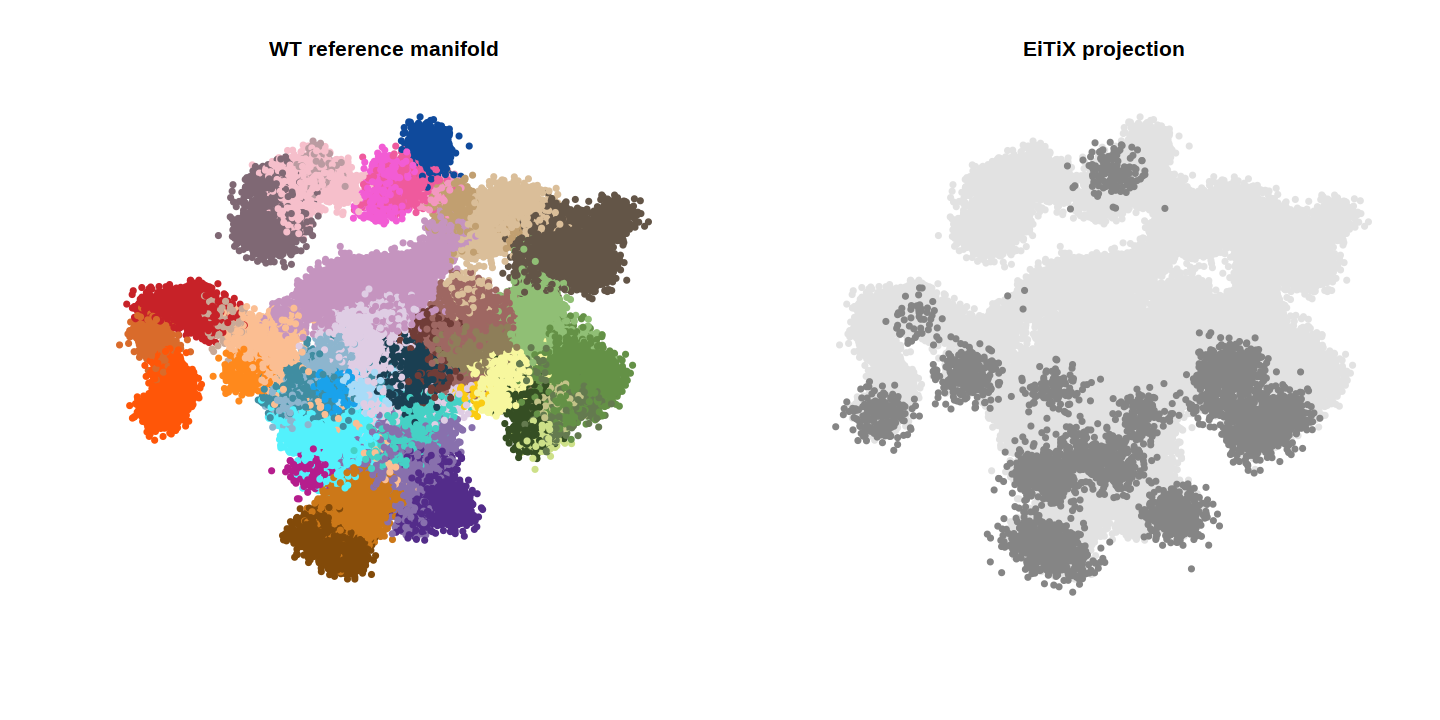

In [37]:
mc2d_wt = scdb_mc2d("emb")

atlas_cells_background_color = rep("#E2E2E2",length(mc2d_wt@sc_x))
names(atlas_cells_background_color) = names(mc2d_wt@sc_x)

query_mcs_vector <- as.numeric(mc_synembs@mc[names(mc_synembs@mc) %in% emb_cls_day8])

best_reference_metacell <- as.numeric(best_reference_emb$best_reference_metacell)[match(query_mcs_vector,names(best_reference_emb$best_reference_metacell))]
names(best_reference_metacell) <- query_mcs_vector

n = length(best_reference_metacell)

mcs <- unique(as.numeric(best_reference_metacell))

xrange = 0.03 * (max(mc2d_wt@mc_x) - min(mc2d_wt@mc_x))
yrange = 0.03 * (max(mc2d_wt@mc_y) - min(mc2d_wt@mc_y))

ref_x = mc2d_wt@mc_x[best_reference_metacell] + rnorm(n, 0, xrange)
ref_y = mc2d_wt@mc_y[best_reference_metacell] + rnorm(n, 0, yrange)

xlim = c(min(mc2d_wt@mc_x), max(mc2d_wt@mc_x))
ylim = c(min(mc2d_wt@mc_y), max(mc2d_wt@mc_y))

f = !is.na(mc2d_wt@sc_x)
all_cells = names(mc2d_wt@sc_x)[f]

cex.points = 0.5
cex.main = 1

# pdf("figs/emb_manifolds_wt_vs_EiTiX_day8.pdf", width = 12, height = 6, useDingbats = F)
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2))
plot(mc2d_wt@sc_x,
     mc2d_wt@sc_y, 
     col = mc_wt@colors[mc_wt@mc[names(mc2d_wt@sc_x)]],
     pch = 19,cex = cex.points,
     xaxt = 'n',yaxt = 'n',
     xlab = "",ylab = "",
     axes = F,
     main = "WT reference manifold",
     cex.main = cex.main)

plot(mc2d_wt@sc_x[all_cells],mc2d_wt@sc_y[all_cells], 
     col = atlas_cells_background_color[all_cells],
     pch = 19,cex = cex.points,xaxt = 'n',yaxt = 'n',xlab = "",ylab = "",
     axes = F,
     main = "EiTiX projection",
     cex.main = cex.main)

points(ref_x, ref_y, pch = 19, col = "#858585", 
ylim = ylim, xlim = xlim,cex = cex.points)

# dev.off()

## Embryoid specific projection of exe day8

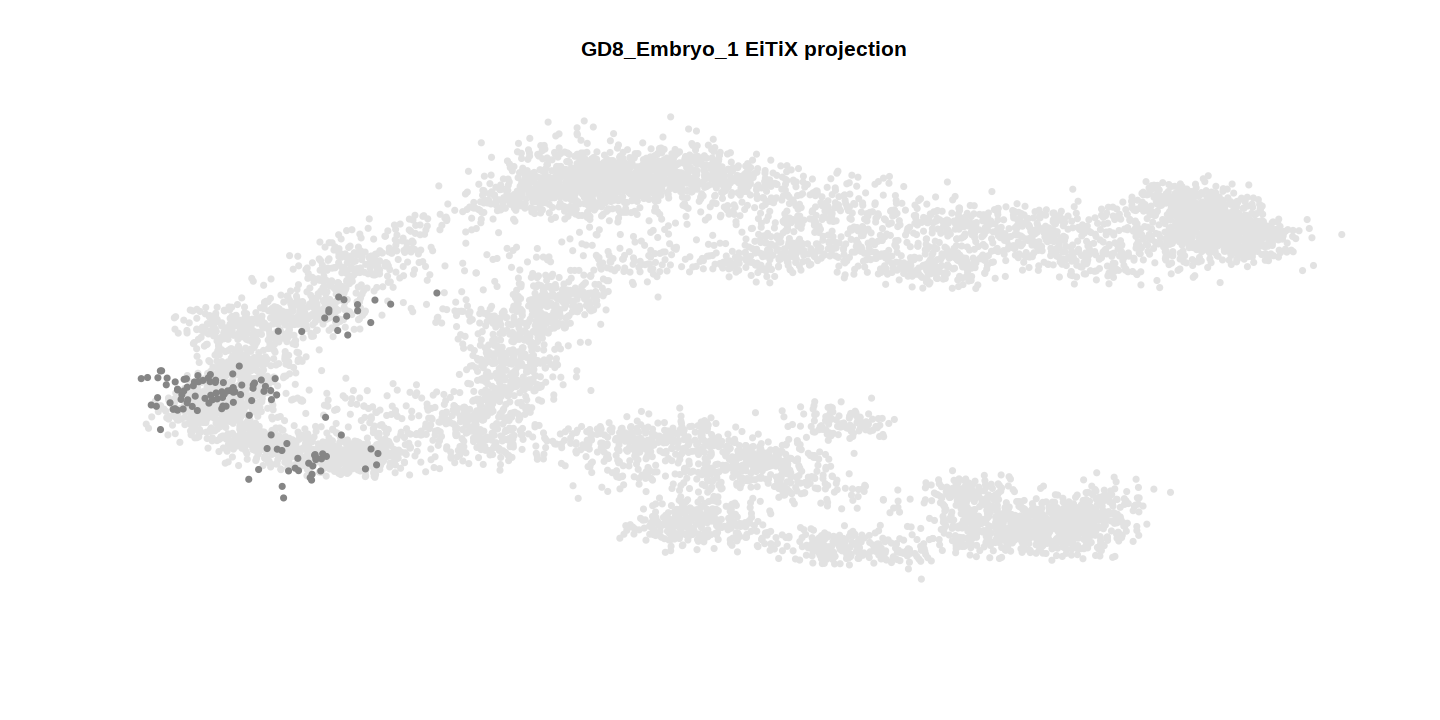

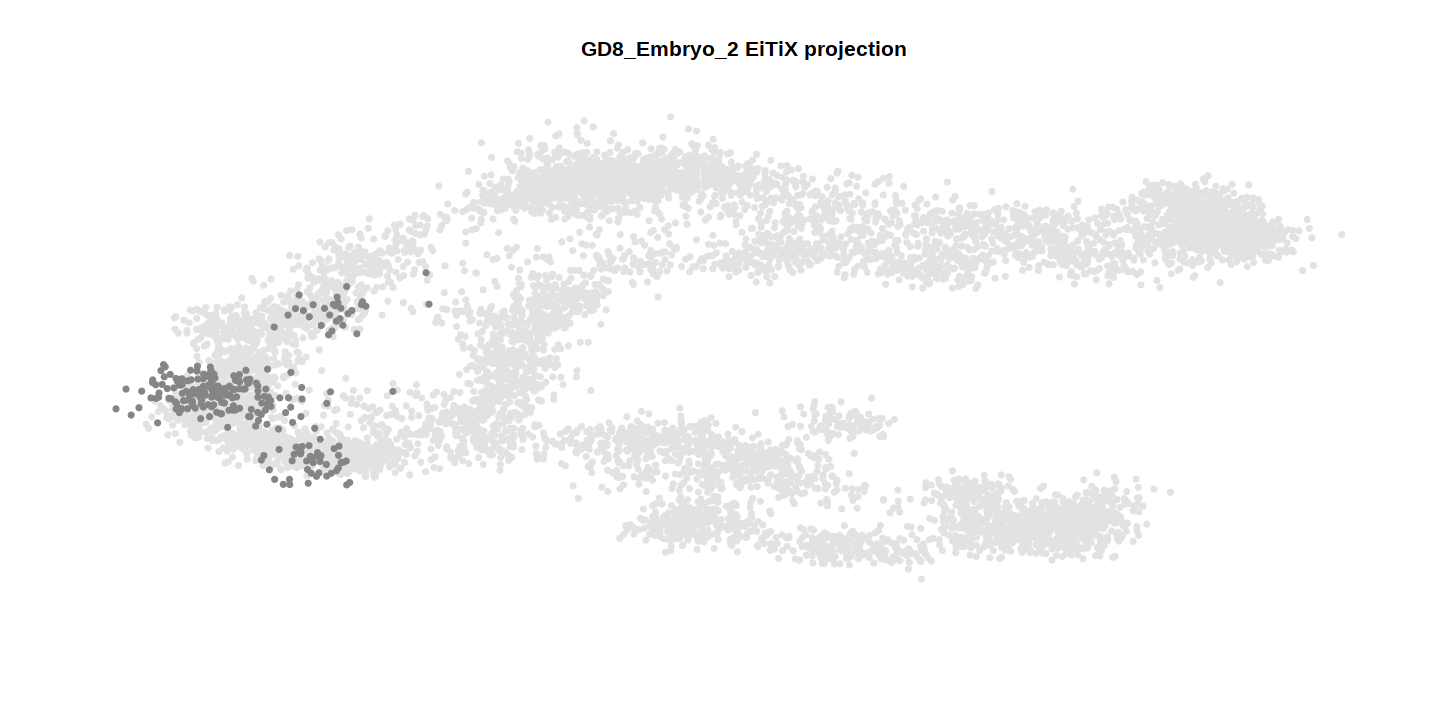

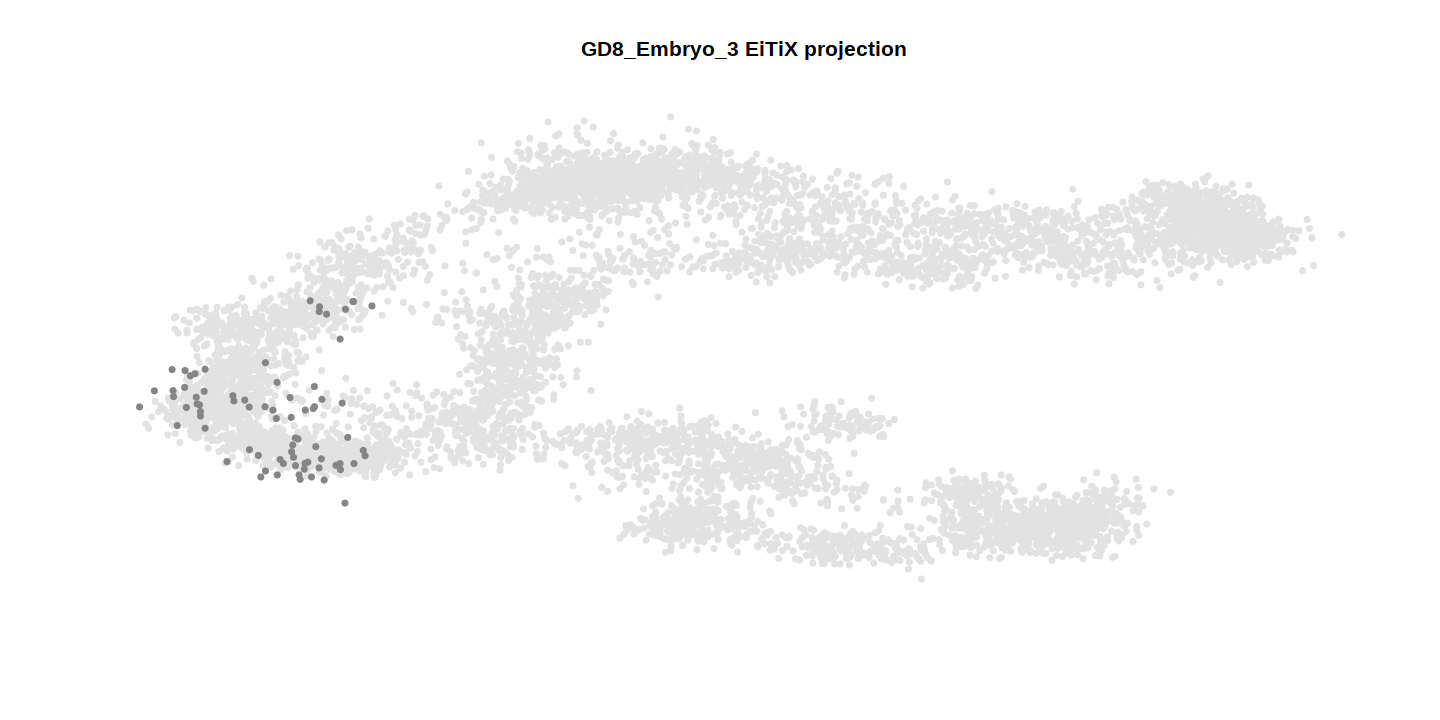

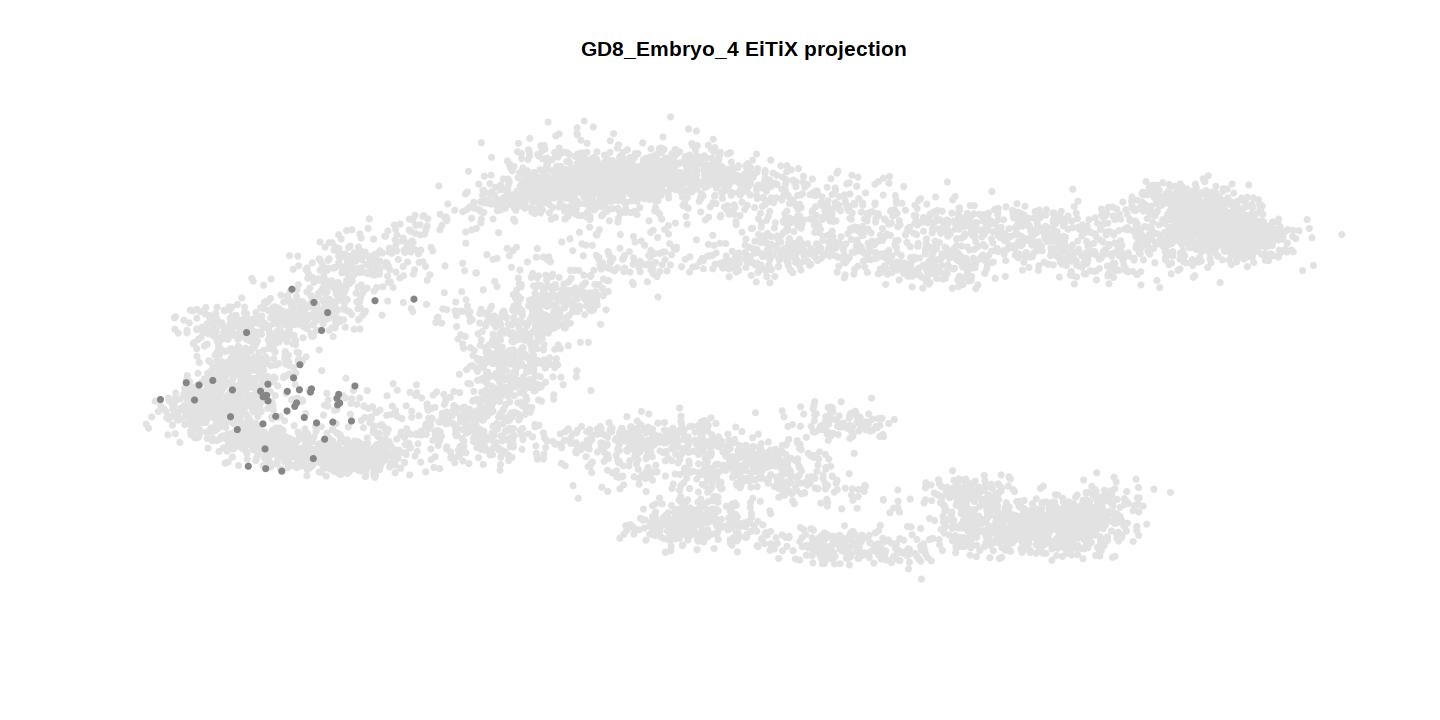

In [38]:
for(emb in synemb_embs_8){
    emb_cls <- rownames(md_synembs)[md_synembs$embryo %in% emb]
    emb_cls <- emb_cls[emb_cls %in% names(mc_synembs@mc)]
    
    mc2d_wt = scdb_mc2d("exe")

    atlas_cells_background_color = rep("#E2E2E2",length(mc2d_wt@sc_x))
    names(atlas_cells_background_color) = names(mc2d_wt@sc_x)

    query_mcs_vector <- as.numeric(mc_synembs@mc[names(mc_synembs@mc) %in% emb_cls])

    best_reference_metacell <- as.numeric(best_reference_exe$best_reference_metacell)[match(query_mcs_vector,names(best_reference_exe$best_reference_metacell))]
    names(best_reference_metacell) <- query_mcs_vector

    n = length(best_reference_metacell)

    mcs <- unique(as.numeric(best_reference_metacell))

    xrange = 0.03 * (max(mc2d_wt@mc_x) - min(mc2d_wt@mc_x))
    yrange = 0.03 * (max(mc2d_wt@mc_y) - min(mc2d_wt@mc_y))

    ref_x = mc2d_wt@mc_x[best_reference_metacell] + rnorm(n, 0, xrange)
    ref_y = mc2d_wt@mc_y[best_reference_metacell] + rnorm(n, 0, yrange)

    xlim = c(min(mc2d_wt@mc_x), max(mc2d_wt@mc_x))
    ylim = c(min(mc2d_wt@mc_y), max(mc2d_wt@mc_y))

    f = !is.na(mc2d_wt@sc_x)
    all_cells = names(mc2d_wt@sc_x)[f]

    cex.points = 0.5
    cex.main = 1

#     pdf(sprintf("figs/exe_manifolds_wt_vs_EiTiX_day8_%s.pdf",emb), width = 6, height = 6, useDingbats = F)

    plot(mc2d_wt@sc_x[all_cells],mc2d_wt@sc_y[all_cells], 
         col = atlas_cells_background_color[all_cells],
         pch = 19,cex = cex.points,xaxt = 'n',yaxt = 'n',xlab = "",ylab = "",
         axes = F,
         main = sprintf("%s EiTiX projection", emb),
         cex.main = cex.main)

    points(ref_x, ref_y, pch = 19, col = "#858585", 
    ylim = ylim, xlim = xlim,cex = cex.points)

#     dev.off()
}


## Embryoid specific projection of embryonic day8

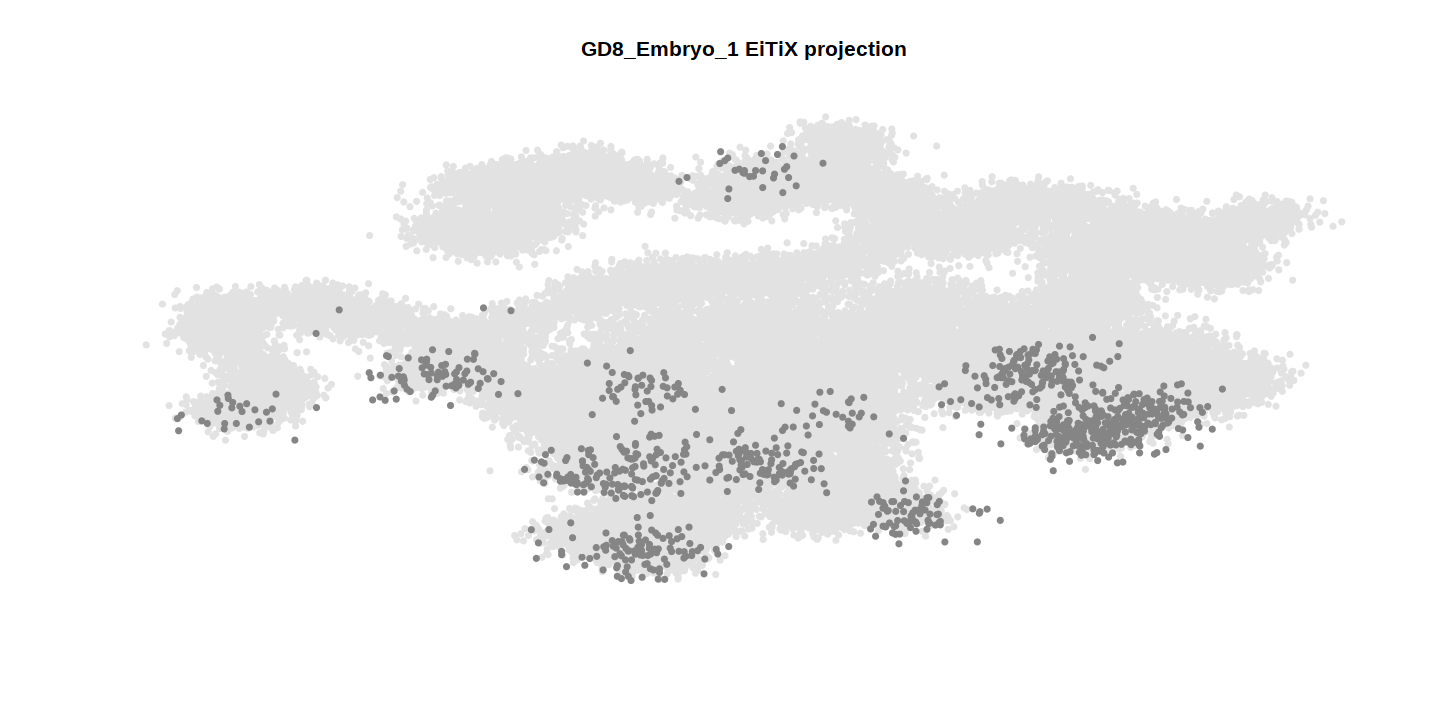

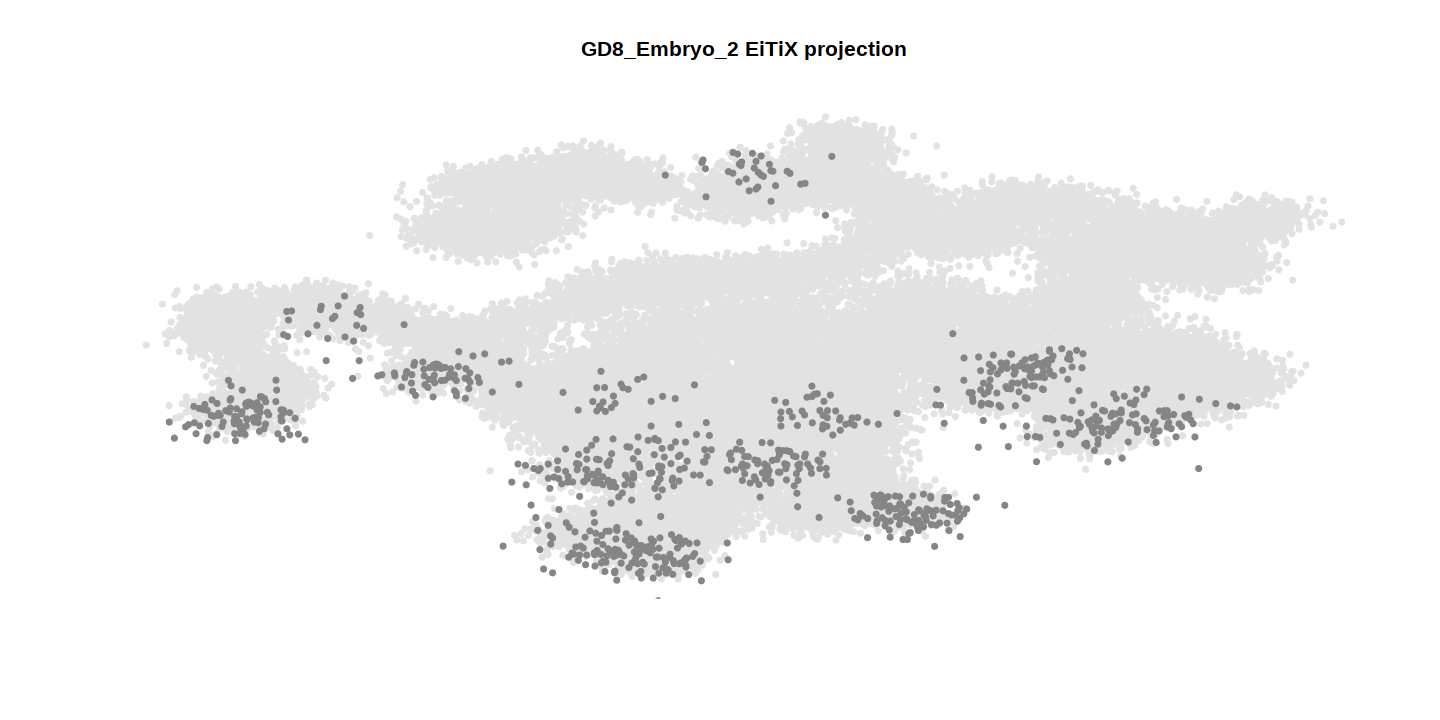

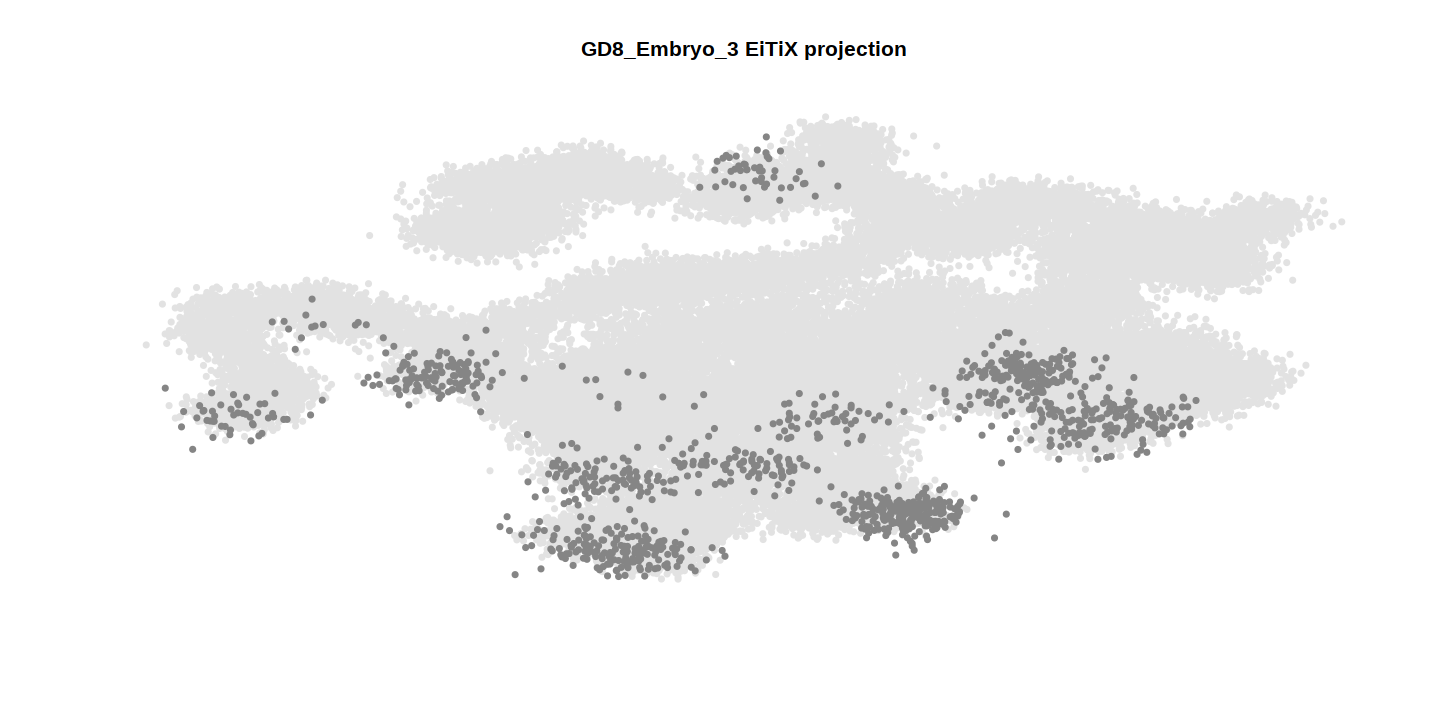

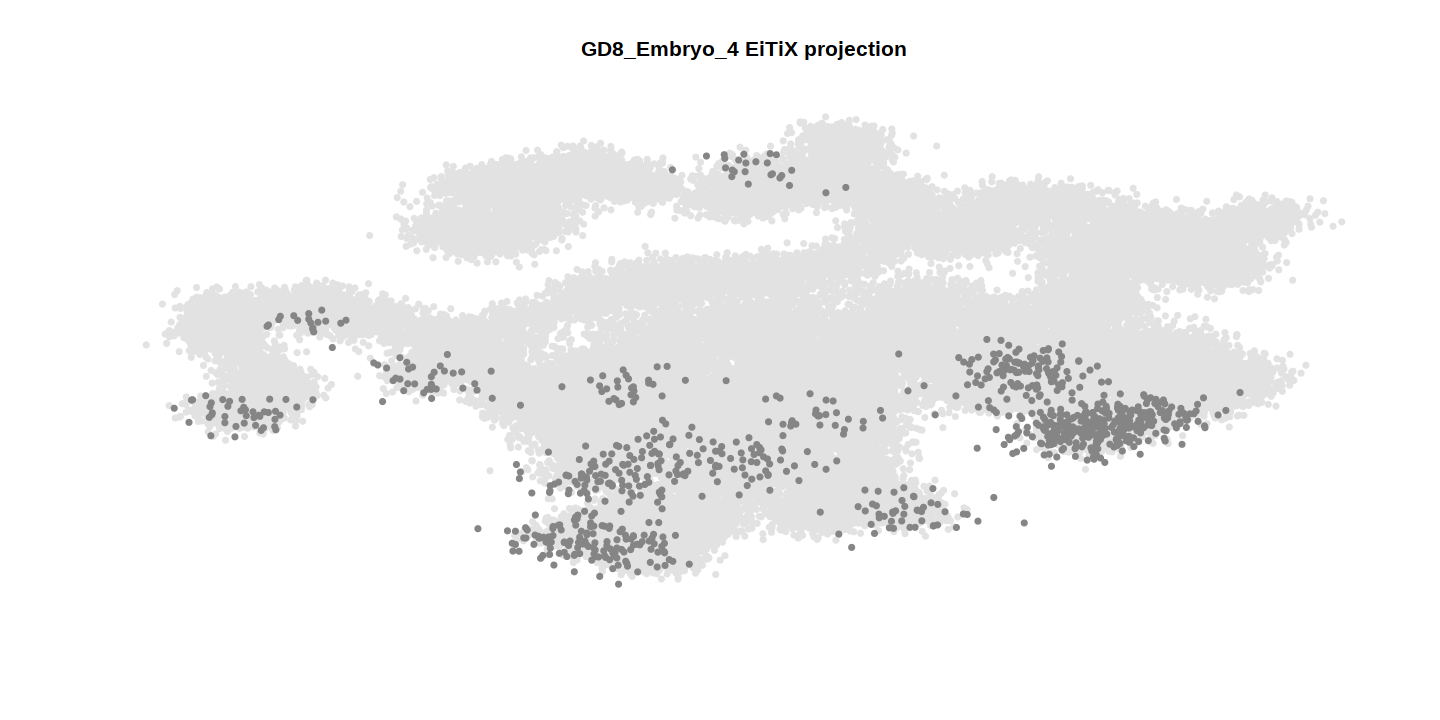

In [39]:
for(emb in synemb_embs_8){
    emb_cls <- rownames(md_synembs)[md_synembs$embryo %in% emb]
    emb_cls <- emb_cls[emb_cls %in% names(mc_synembs@mc)]
    
    mc2d_wt = scdb_mc2d("emb")

    atlas_cells_background_color = rep("#E2E2E2",length(mc2d_wt@sc_x))
    names(atlas_cells_background_color) = names(mc2d_wt@sc_x)

    query_mcs_vector <- as.numeric(mc_synembs@mc[names(mc_synembs@mc) %in% emb_cls])

    best_reference_metacell <- as.numeric(best_reference_emb$best_reference_metacell)[match(query_mcs_vector,names(best_reference_emb$best_reference_metacell))]
    names(best_reference_metacell) <- query_mcs_vector

    n = length(best_reference_metacell)

    mcs <- unique(as.numeric(best_reference_metacell))

    xrange = 0.03 * (max(mc2d_wt@mc_x) - min(mc2d_wt@mc_x))
    yrange = 0.03 * (max(mc2d_wt@mc_y) - min(mc2d_wt@mc_y))

    ref_x = mc2d_wt@mc_x[best_reference_metacell] + rnorm(n, 0, xrange)
    ref_y = mc2d_wt@mc_y[best_reference_metacell] + rnorm(n, 0, yrange)

    xlim = c(min(mc2d_wt@mc_x), max(mc2d_wt@mc_x))
    ylim = c(min(mc2d_wt@mc_y), max(mc2d_wt@mc_y))

    f = !is.na(mc2d_wt@sc_x)
    all_cells = names(mc2d_wt@sc_x)[f]

    cex.points = 0.5
    cex.main = 1

#     pdf(sprintf("figs/emb_manifolds_wt_vs_EiTiX_day8_%s.pdf",emb), width = 6, height = 6, useDingbats = F)

    plot(mc2d_wt@sc_x[all_cells],mc2d_wt@sc_y[all_cells], 
         col = atlas_cells_background_color[all_cells],
         pch = 19,cex = cex.points,xaxt = 'n',yaxt = 'n',xlab = "",ylab = "",
         axes = F,
         main = sprintf("%s EiTiX projection", emb),
         cex.main = cex.main)

    points(ref_x, ref_y, pch = 19, col = "#858585", 
    ylim = ylim, xlim = xlim,cex = cex.points)

#     dev.off()
}
